# Описание проекта
Данные находятся в трёх файлах:

* gold_recovery_train_new.csv — обучающая выборка;
* gold_recovery_test_new.csv — тестовая выборка;
* gold_recovery_full_new.csv — исходные данные.


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.


Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.


Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.


В распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверить по инструкции их на корректность.

## Описание данных

* Технологический процесс
    * Rougher feed — исходное сырье
    * Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  
        * Xanthate — ксантогенат (промотер, или активатор флотации);
    
        * Sulphate — сульфат (на данном производстве сульфид натрия);
    
        * Depressant — депрессант (силикат натрия).
    
    * Rougher process (англ. «грубый процесс») — флотация
    
    * Rougher tails — отвальные хвосты
    
    * Float banks — флотационная установка
    
    * Cleaner process — очистка
    
    * Rougher Au — черновой концентрат золота
    
    * Final Au — финальный концентрат золота
    
* Параметры этапов

    * air amount — объём воздуха
    
    * fluid levels — уровень жидкости
    
    * feed size — размер гранул сырья
    
    * feed rate — скорость подачи
    
## Наименование признаков

* Наименование признаков должно быть такое:

    * [этап].[тип_параметра].[название_параметра]
    
    * Пример: rougher.input.feed_ag
    
* Возможные значения для блока [этап]:

    * rougher — флотация
    
    * primary_cleaner — первичная очистка
    
    * secondary_cleaner — вторичная очистка
    
    * final — финальные характеристики
    
* Возможные значения для блока [тип_параметра]:

    * input — параметры сырья
    
    * output — параметры продукта
    
    * state — параметры, характеризующие текущее состояние этапа
    
    * calculation — расчётные характеристики


## План выполнения проекта 

#### 1. Подготовка данных


* 1.1. Изучение файлов.

    Путь к файлам:

    * /datasets/gold_recovery_train_new.csv
    * /datasets/gold_recovery_test_new.csv
    * /datasets/gold_recovery_full_new.csv


* 1.2. Проверка, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака. Описание выводов.


* 1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?


* 1.4. Провести предобработку данных.



#### 2. Анализ данных


* 2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описание выводов.


* 2.2.  Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.


* 2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 


#### 3. Построение модели

* Нужно спрогнозировать сразу две величины:
    * эффективность обогащения чернового концентрата rougher.output.recovery
    * эффективность обогащения финального концентрата final.output.recovery

* 3.1. Написать функцию для вычисления итоговой sMAPE.


* 3.2. Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. Описание выводов.



## Необходимые формулы: 

* #### $ {RECOVERY} = \frac{C * (F - T)}{F * (C - T)}  $
    * C — доля золота в концентрате после флотации/очистки;
    * F — доля золота в сырье/концентрате до флотации/очистки;
    * T — доля золота в отвальных хвостах после флотации/очистки.

* #### $sMAPE = \frac{1}{N} \sum_{i=1}^N \frac{|y_i - y_i^*|}{(\frac{|y_i|+|y_i^*|}{2})} * 100\% $
    * $y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

    * $y_i^*$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
    
* #### $sMAPE_{total} = 25\% * sMAPE_{rougher} + 75\% * sMAPE_{final}$

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor

from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#### 1. Подготовка данных

#### 1.1. Изучение файлов.

In [2]:
try: 
    rec_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
    rec_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
    rec_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
except: 
    rec_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date')
    rec_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date')
    rec_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date')
    
pd.set_option('display.max_columns', None)
data = dict({'train': rec_train, 'test': rec_test, 'full': rec_full})

In [3]:
RND = 123

In [4]:
for name in data: 
    print('_'*100)
    print('***', name, '***')
    print(data[name].info())
    display(data[name].head())
    print(data[name].isna().sum())
    print('_')

____________________________________________________________________________________________________
*** train ***
<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.ta

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64
_
____________________________________________________________________________________________________
*** test ***
<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.s

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64
_


Типы данных соответствуют своим значениям. В трех датасетах присутствуют пропуски. Заменим пропуски значениями, которые находятся на строку выше.

In [5]:
for name in data: 
    data[name].fillna(method='ffill', inplace=True)
    print(data[name].isna().sum().sum())

0
0
0


#### 1.2. Проверка, что эффективность обогащения рассчитана правильно. Вычислить её на обучающей выборке для признака rougher.output.recovery. Найти MAE между расчётами и значением признака. Описание выводов.

* #### $ {RECOVERY} = \frac{C * (F - T)}{F * (C - T)}  $

In [6]:
df = data['train']
df = df[['rougher.output.recovery',  #recovery 
        'rougher.output.concentrate_au', # C
        'rougher.input.feed_au', # F
        'rougher.output.tail_au']] # T
df.columns = ['recovery', 'C', 'F', 'T']
df1 = df.copy()
df1['rec_formula'] = 100 * df.loc[:, 'C'] * (df.loc[:, 'F'] - df.loc[:,'T']) /(df.loc[:, 'F'] 
                                                    * (df.loc[:, 'C'] - df.loc[:,'T']))
print('MAE:', mean_absolute_error(df1['recovery'], df1['rec_formula']))

MAE: 1.1498046842860452e-14


Ошибка получилась 14 порядка малости, значит эффективность обогащения рассчитана правильно.

#### 1.3. Проанализировать признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [7]:
set_train = set(data['train'].columns)
set_test = set(data['test'].columns)
diff = set_train - set_test
diff

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Недостающие колонки признаков в тестовом датасете: 

________________________________________________
Солбцы 'C' для $RECOVERY_{final}$ (параметры продукта) разных металлов:

* 'final.output.concentrate_ag'
 
* 'final.output.concentrate_au'
 
* 'final.output.concentrate_pb'
 
* 'final.output.concentrate_sol'

________________________________________________
Солбцы 'T' для $RECOVERY_{final}$ (параметры продукта) разных металлов:

* 'final.output.tail_ag'
 
* 'final.output.tail_au'
 
* 'final.output.tail_pb'
 
* 'final.output.tail_sol'
 
________________________________________________
Солбцы 'C' для $RECOVERY_{primarycleaner}$ (параметры продукта) разных металлов:

* 'primary_cleaner.output.concentrate_ag'
 
* 'primary_cleaner.output.concentrate_au'
 
* 'primary_cleaner.output.concentrate_pb'
 
* 'primary_cleaner.output.concentrate_sol'

________________________________________________
Солбцы 'T' для $RECOVERY_{primarycleaner}$ (параметры продукта) разных металлов: 

* 'primary_cleaner.output.tail_ag'
 
* 'primary_cleaner.output.tail_au'
 
* 'primary_cleaner.output.tail_pb'
 
* 'primary_cleaner.output.tail_sol'

________________________________________________
Расчетные характеристики: 

* 'rougher.calculation.au_pb_ratio'
 
* 'rougher.calculation.floatbank10_sulfate_to_au_feed'
 
* 'rougher.calculation.floatbank11_sulfate_to_au_feed'
 
* 'rougher.calculation.sulfate_to_au_concentrate'

________________________________________________

Солбцы 'C' для $RECOVERY_{rougher}$ (параметры продукта) разных металлов:  
 
* 'rougher.output.concentrate_ag'
 
* 'rougher.output.concentrate_au'
 
* 'rougher.output.concentrate_pb'
 
* 'rougher.output.concentrate_sol'
 
________________________________________________
 
Солбцы 'T' для $RECOVERY_{rougher}$ (параметры продукта) разных металлов: 

* 'rougher.output.tail_ag'
 
* 'rougher.output.tail_au'
 
* 'rougher.output.tail_pb'
 
* 'rougher.output.tail_sol'
 
________________________________________________

Солбцы 'T' для $RECOVERY_{secondarycleaner}$ (параметры продукта) разных металлов: 

* 'secondary_cleaner.output.tail_ag'
 
* 'secondary_cleaner.output.tail_au'
 
* 'secondary_cleaner.output.tail_pb'
 
* 'secondary_cleaner.output.tail_sol'
________________________________________________
 
 Все эти признаки могли позволить нам расчитать целевые признаки без предсказаний, т.к. в них содержалась информация о столбцах C, T для  (кроме calculation). Все они относятся к типу float. Нужно исключить их из обучающего датасета, чтобы модель обучилась правильно. 

#### 1.4. Провести предобработку данных.

Ранее были заполнены пропуски во всех трех датасетах. Оставим данные, которые будут лежать в отрезке 0.2% и 99.7% квантилей (в обучающей выборке), также удалим из обучающей выборки признаки, которые отсутствуют в тестовой.

Удаление лишних признаков: 

In [8]:
set_train = set(data['train'].columns)
set_test = set(data['test'].columns)
set_target = set(['rougher.output.recovery', 'final.output.recovery'])
diff = set_train - set_test - set_target
data['train'].drop(diff, axis=1, inplace=True)

Удаление выбросов: 

In [9]:
df = data['train'].copy()

In [10]:
q_min = df.quantile(q=0.003)
q_max = df.quantile(q=0.997)
count = len(df)
data['train'] = df[~((df < q_min) | (df > q_max)).any(axis=1)]
len(data['train'])
print('Часть удаленных данных: ', round(1 - (len(data['train']) / len(df)), 4))

Часть удаленных данных:  0.2014


Проверка на мультиколлинеарность

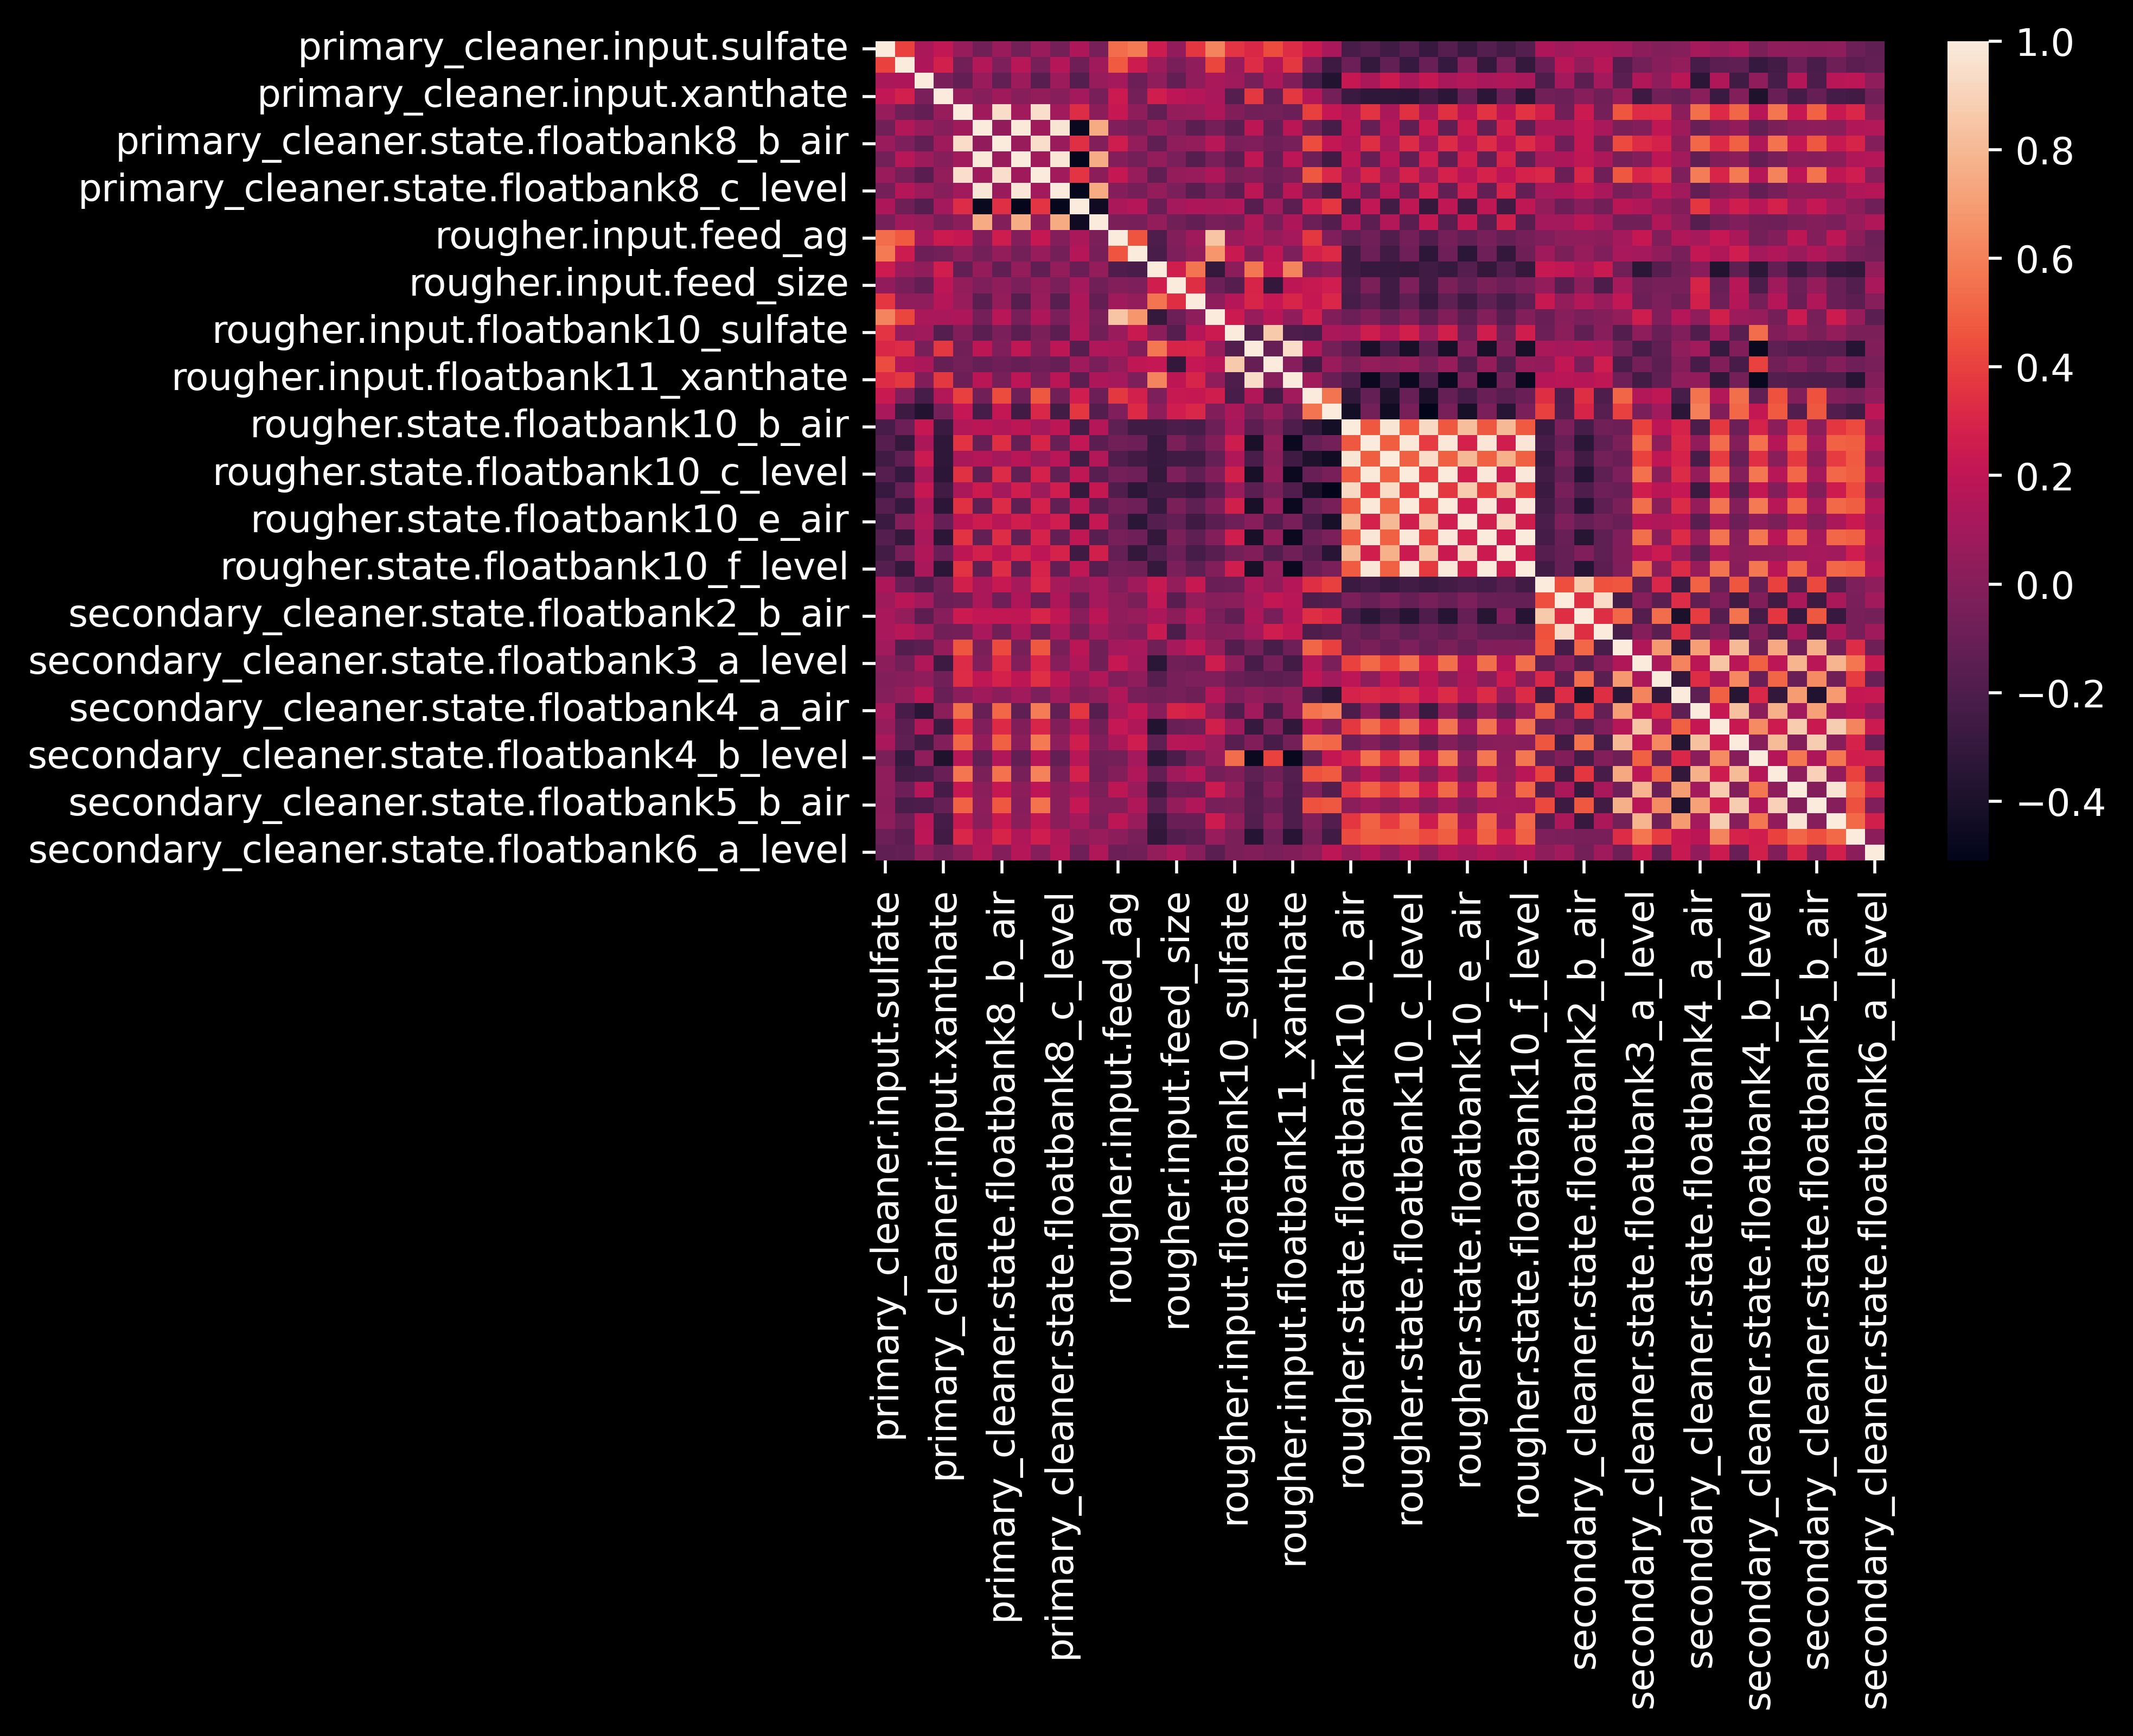

In [11]:
plt.style.use('dark_background')
plt.figure(dpi=500)
df = data['train'].copy()
df = df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
matrix = df.corr()
sns.heatmap(matrix)
plt.show()

Заметим, что в признаках присутствует корреляция, выделим те признаки, которое коррелируют с остальными. 

In [12]:
df = data['train'].copy()
X = df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
vif_data = pd.DataFrame()
vif_data[ "feature" ] = X.columns
vif_data[ "VIF" ] = [variance_inflation_factor(X.values, i) for i in range ( len (X.columns))]
display(vif_data.sort_values(by='VIF', ascending=False))



,feature,VIF
27,rougher.state.floatbank10_c_level,15565.067000
31,rougher.state.floatbank10_e_level,14092.523622
7,primary_cleaner.state.floatbank8_b_level,12679.601726
5,primary_cleaner.state.floatbank8_a_level,11881.751895
29,rougher.state.floatbank10_d_level,10835.111336
33,rougher.state.floatbank10_f_level,10592.923264
9,primary_cleaner.state.floatbank8_c_level,7381.536131
8,primary_cleaner.state.floatbank8_c_air,4261.728462
49,secondary_cleaner.state.floatbank5_b_level,4074.710091
47,secondary_cleaner.state.floatbank5_a_level,4058.867796


VIF достигает значений, превышающих 14000. Большое количество признаков зависят друг от друга. При необходимости, удалим признаки, сильно коррелирующие с другими. 

#### 2.1. Посмотреть, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Описание выводов.


Нужные колонки:
_____________________________________
rougher.input.feed_pb

rougher.input.feed_rate

rougher.input.feed_size

rougher.input.feed_sol

rougher.input.feed_au
_____________________________________
rougher.output.concentrate_ag

rougher.output.concentrate_au

rougher.output.concentrate_pb

rougher.output.concentrate_sol
_____________________________________
primary_cleaner.output.concentrate_ag

primary_cleaner.output.concentrate_au

primary_cleaner.output.concentrate_pb

primary_cleaner.output.concentrate_sol
_____________________________________
final.output.concentrate_ag

final.output.concentrate_pb

final.output.concentrate_sol

final.output.concentrate_au   

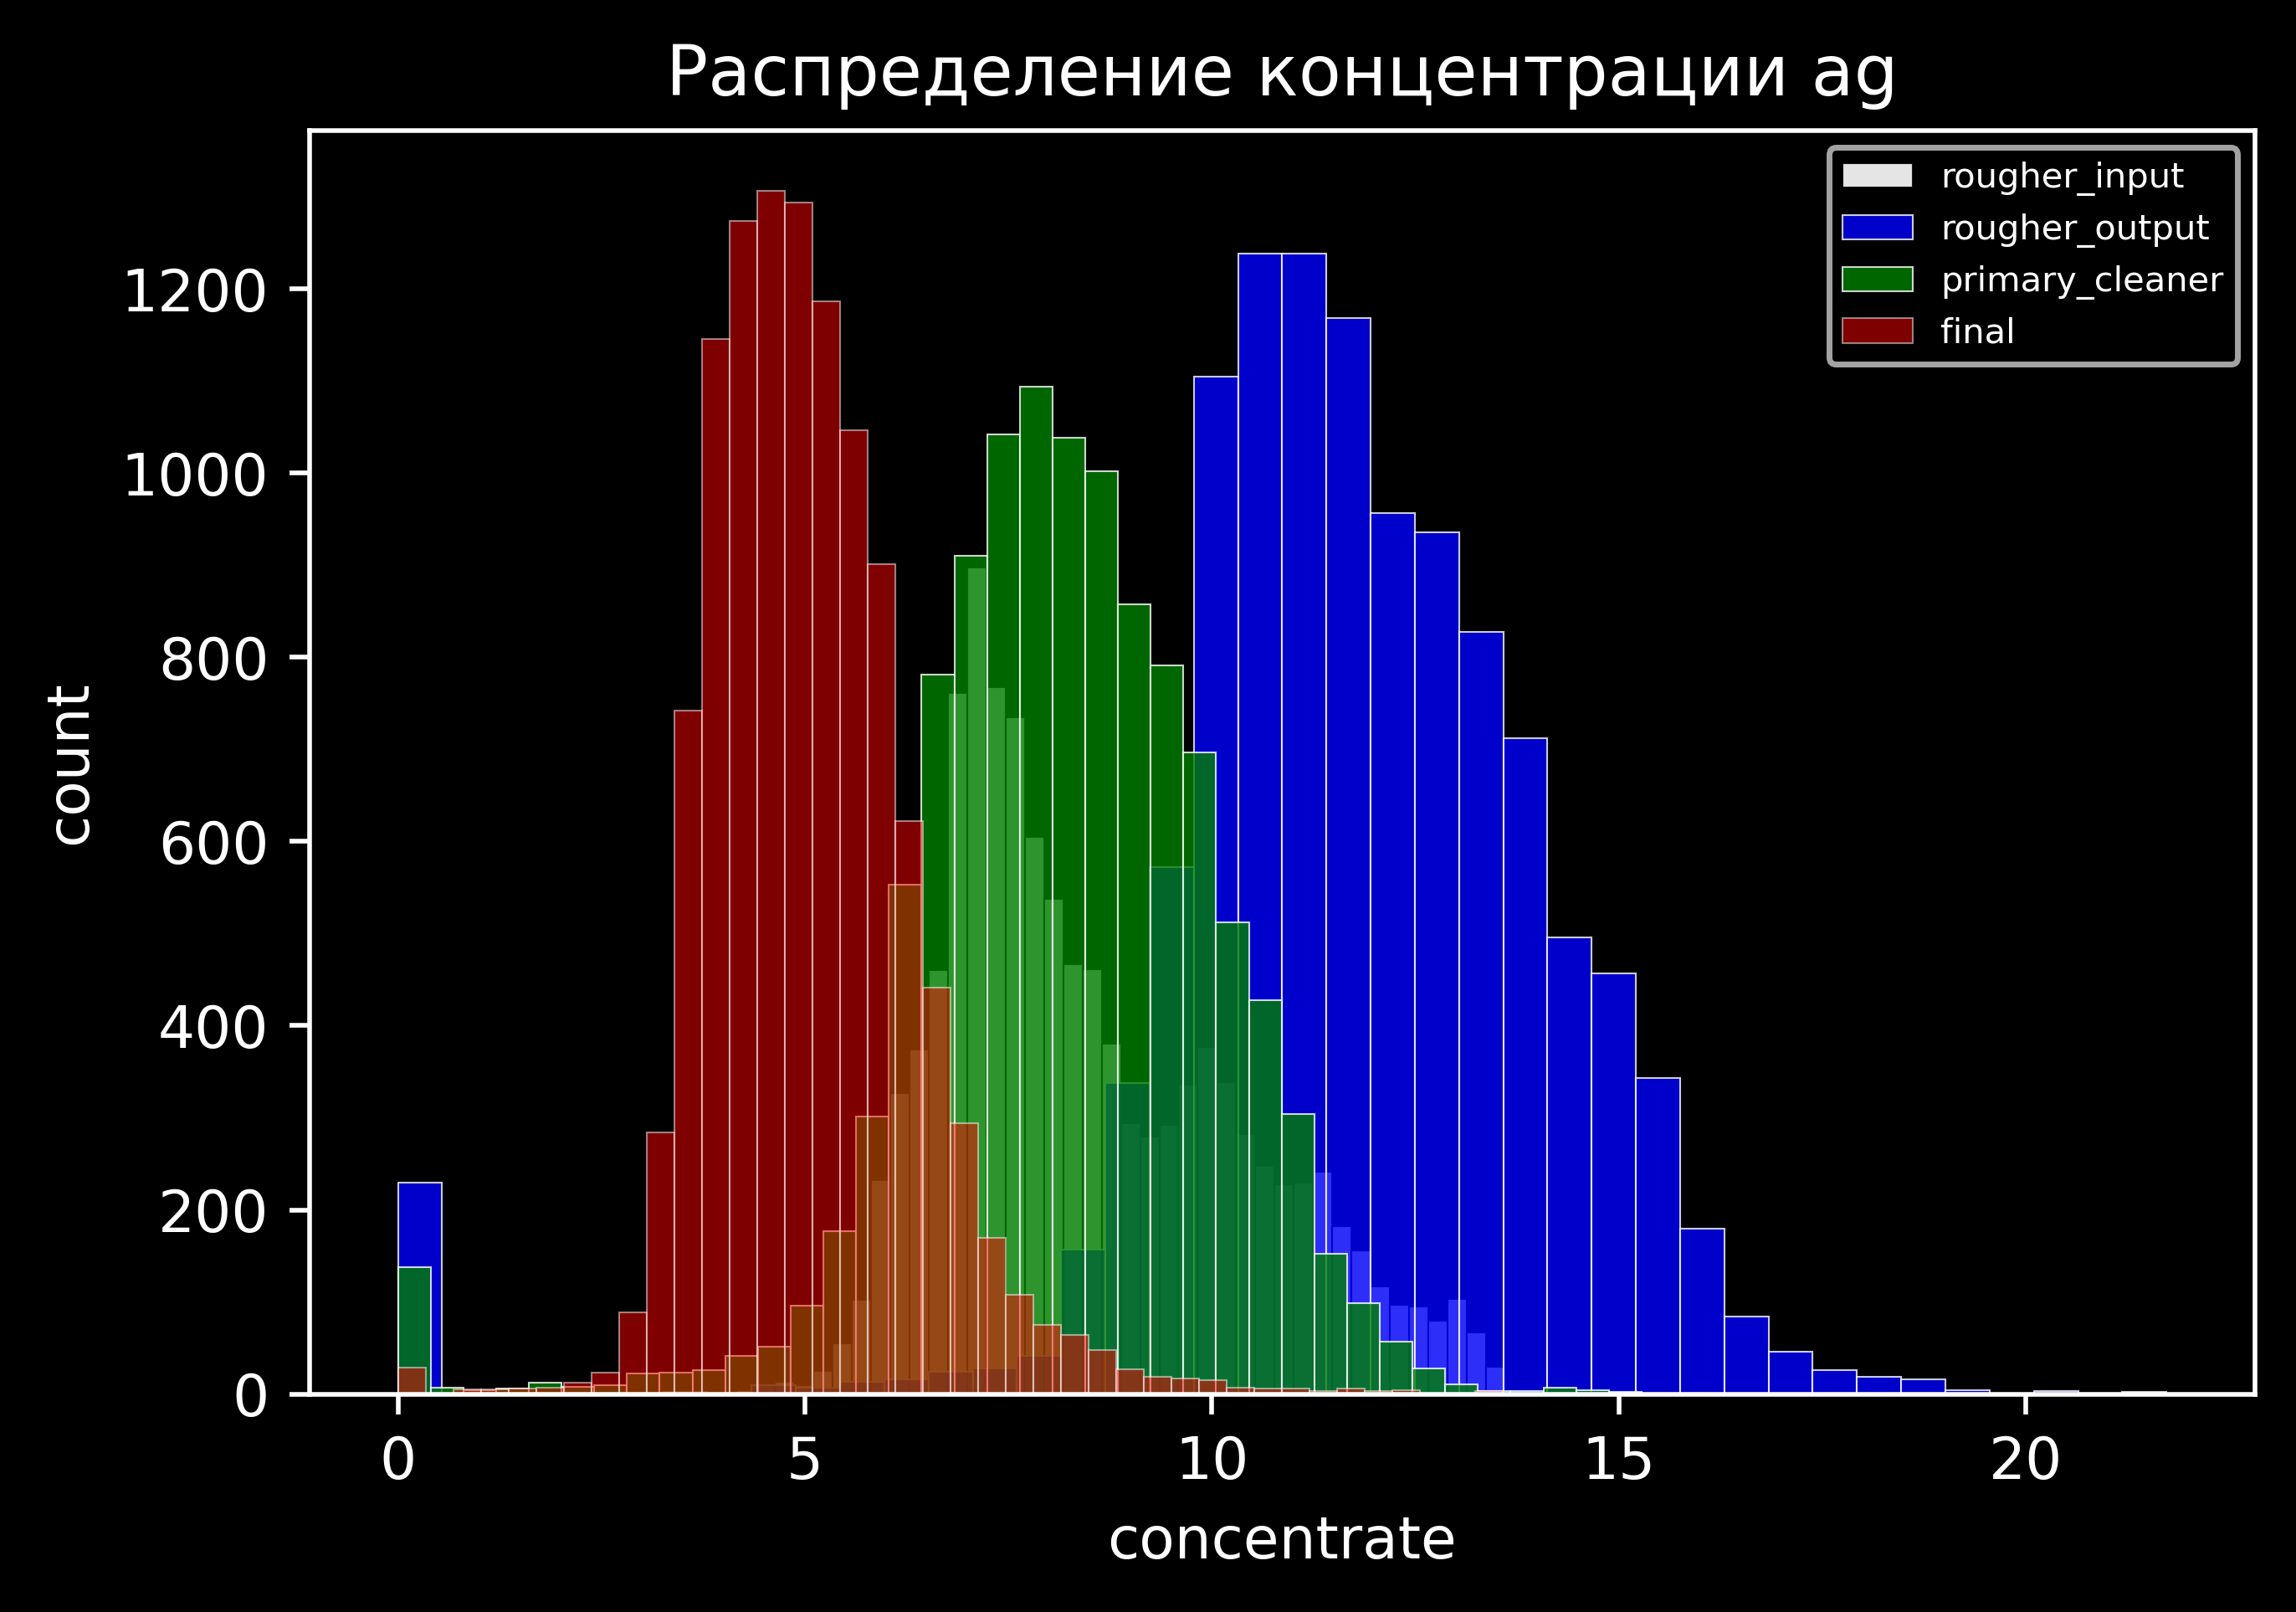

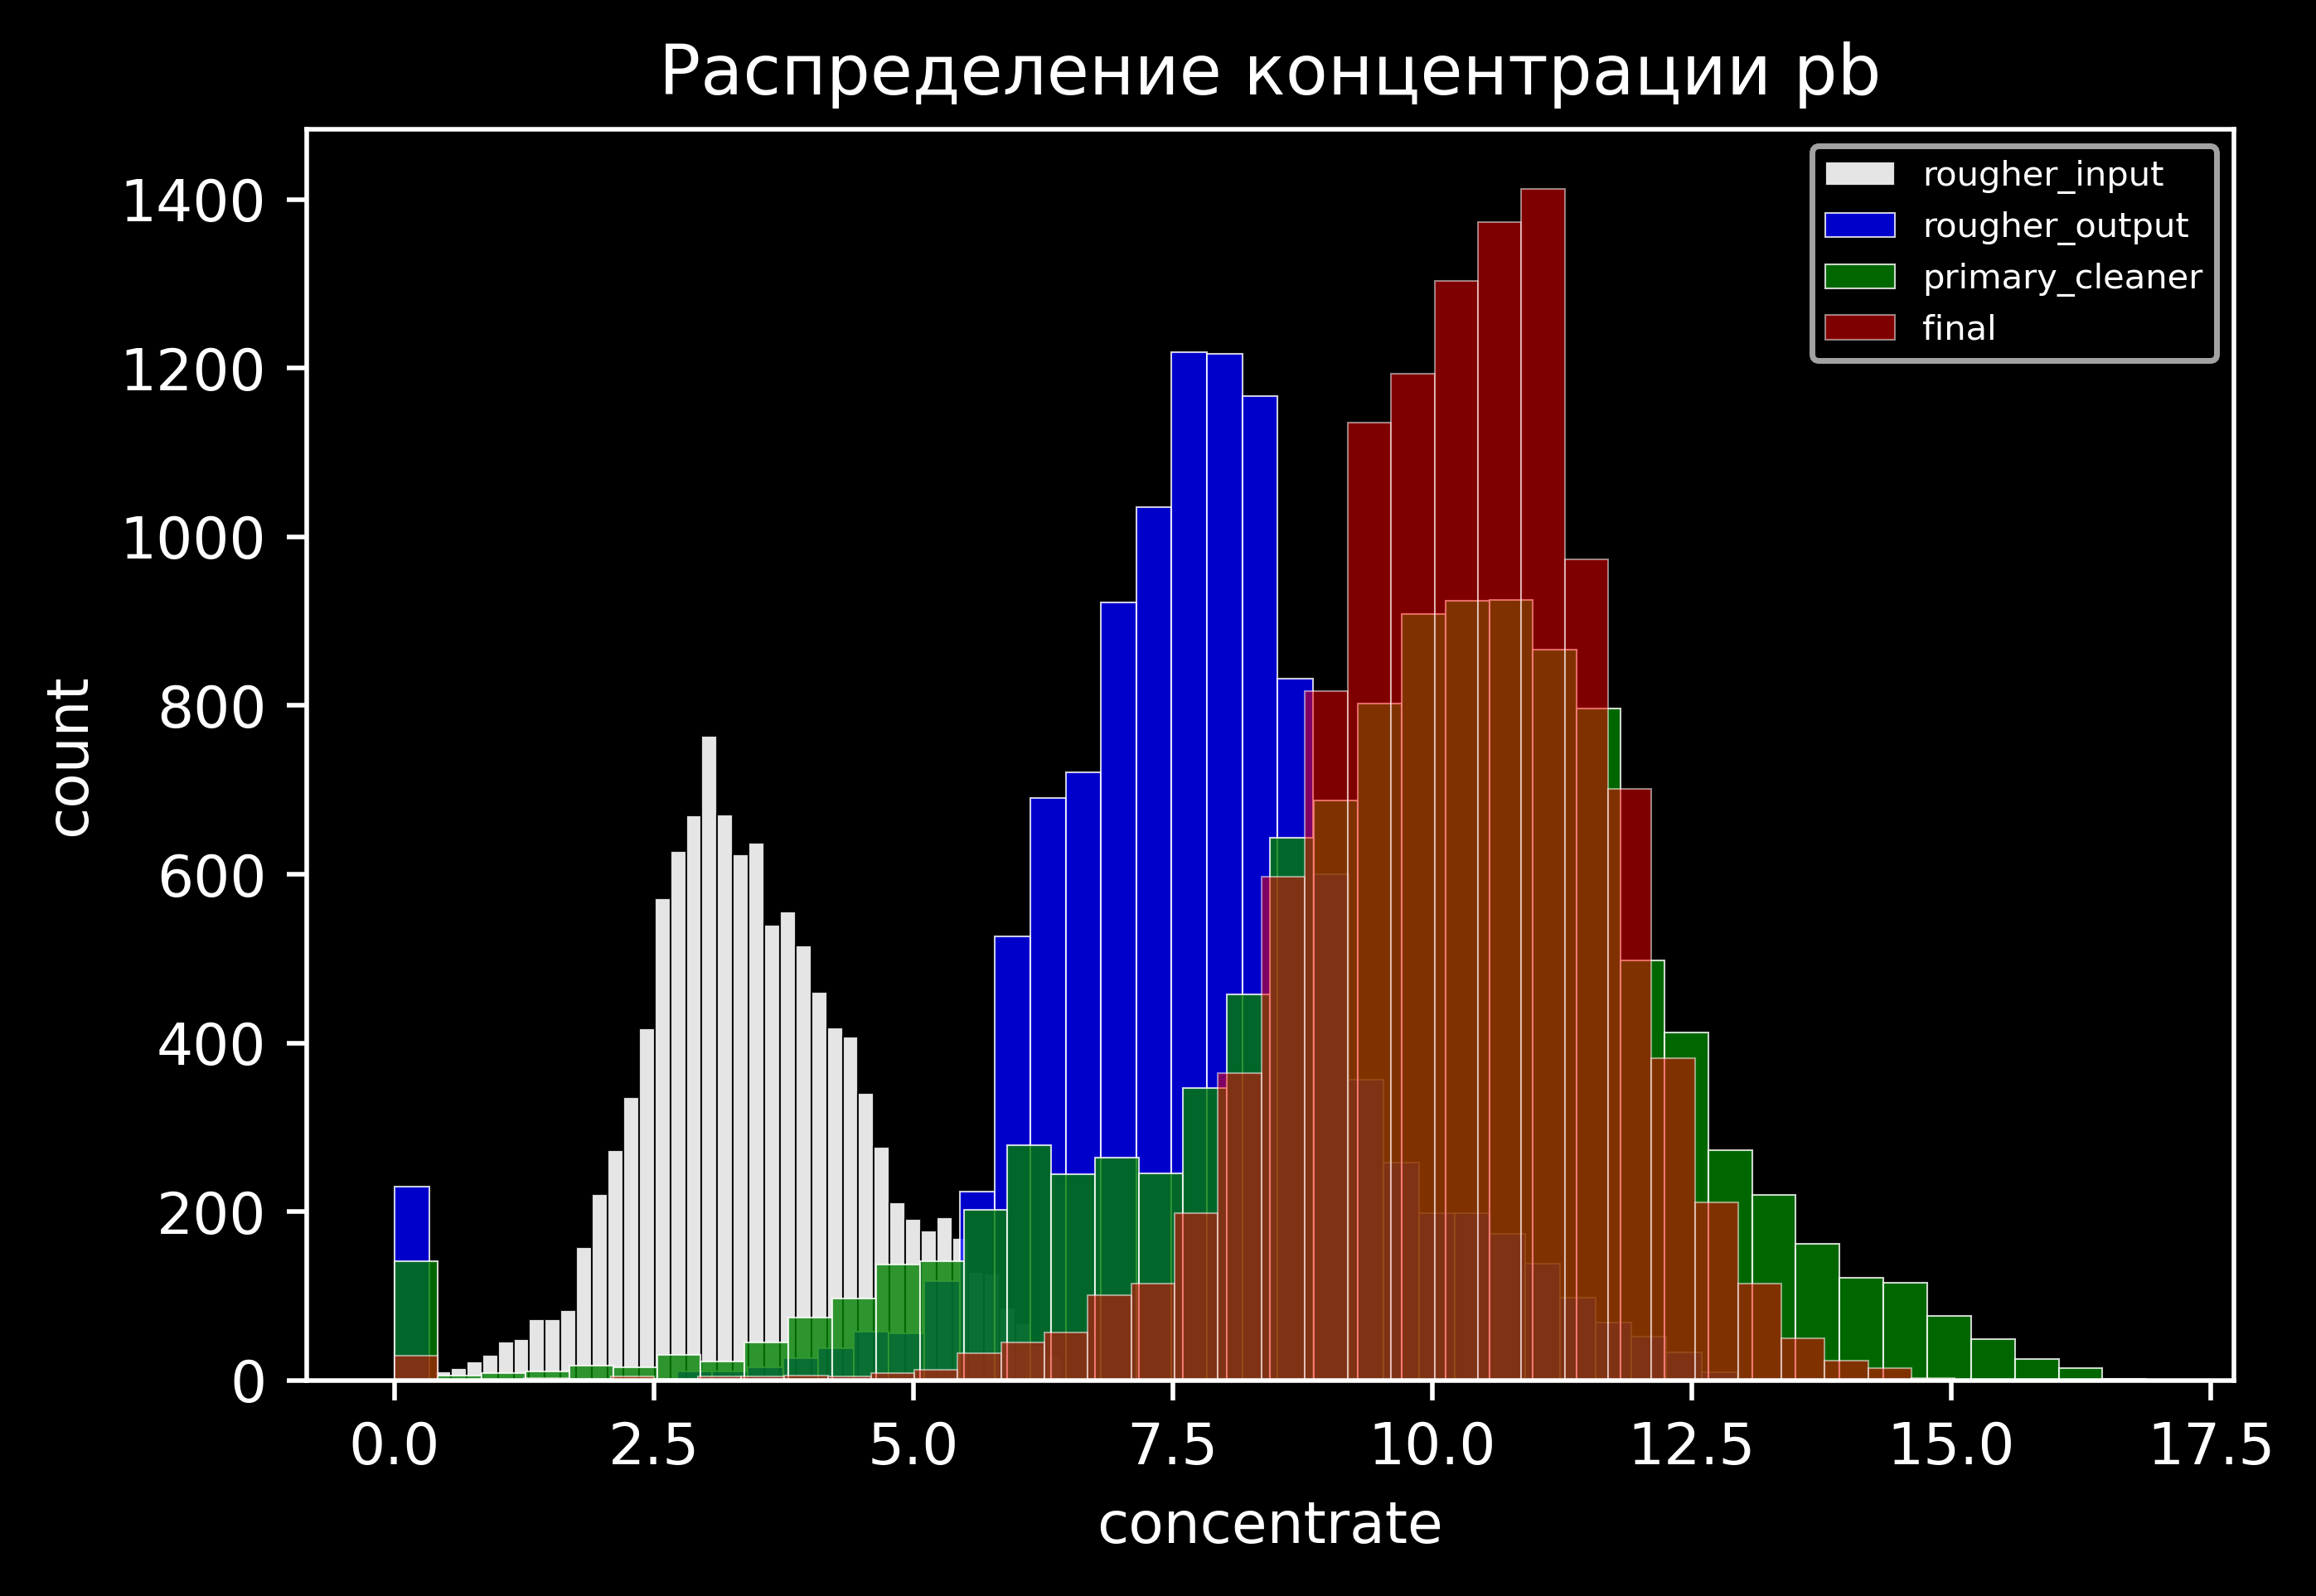

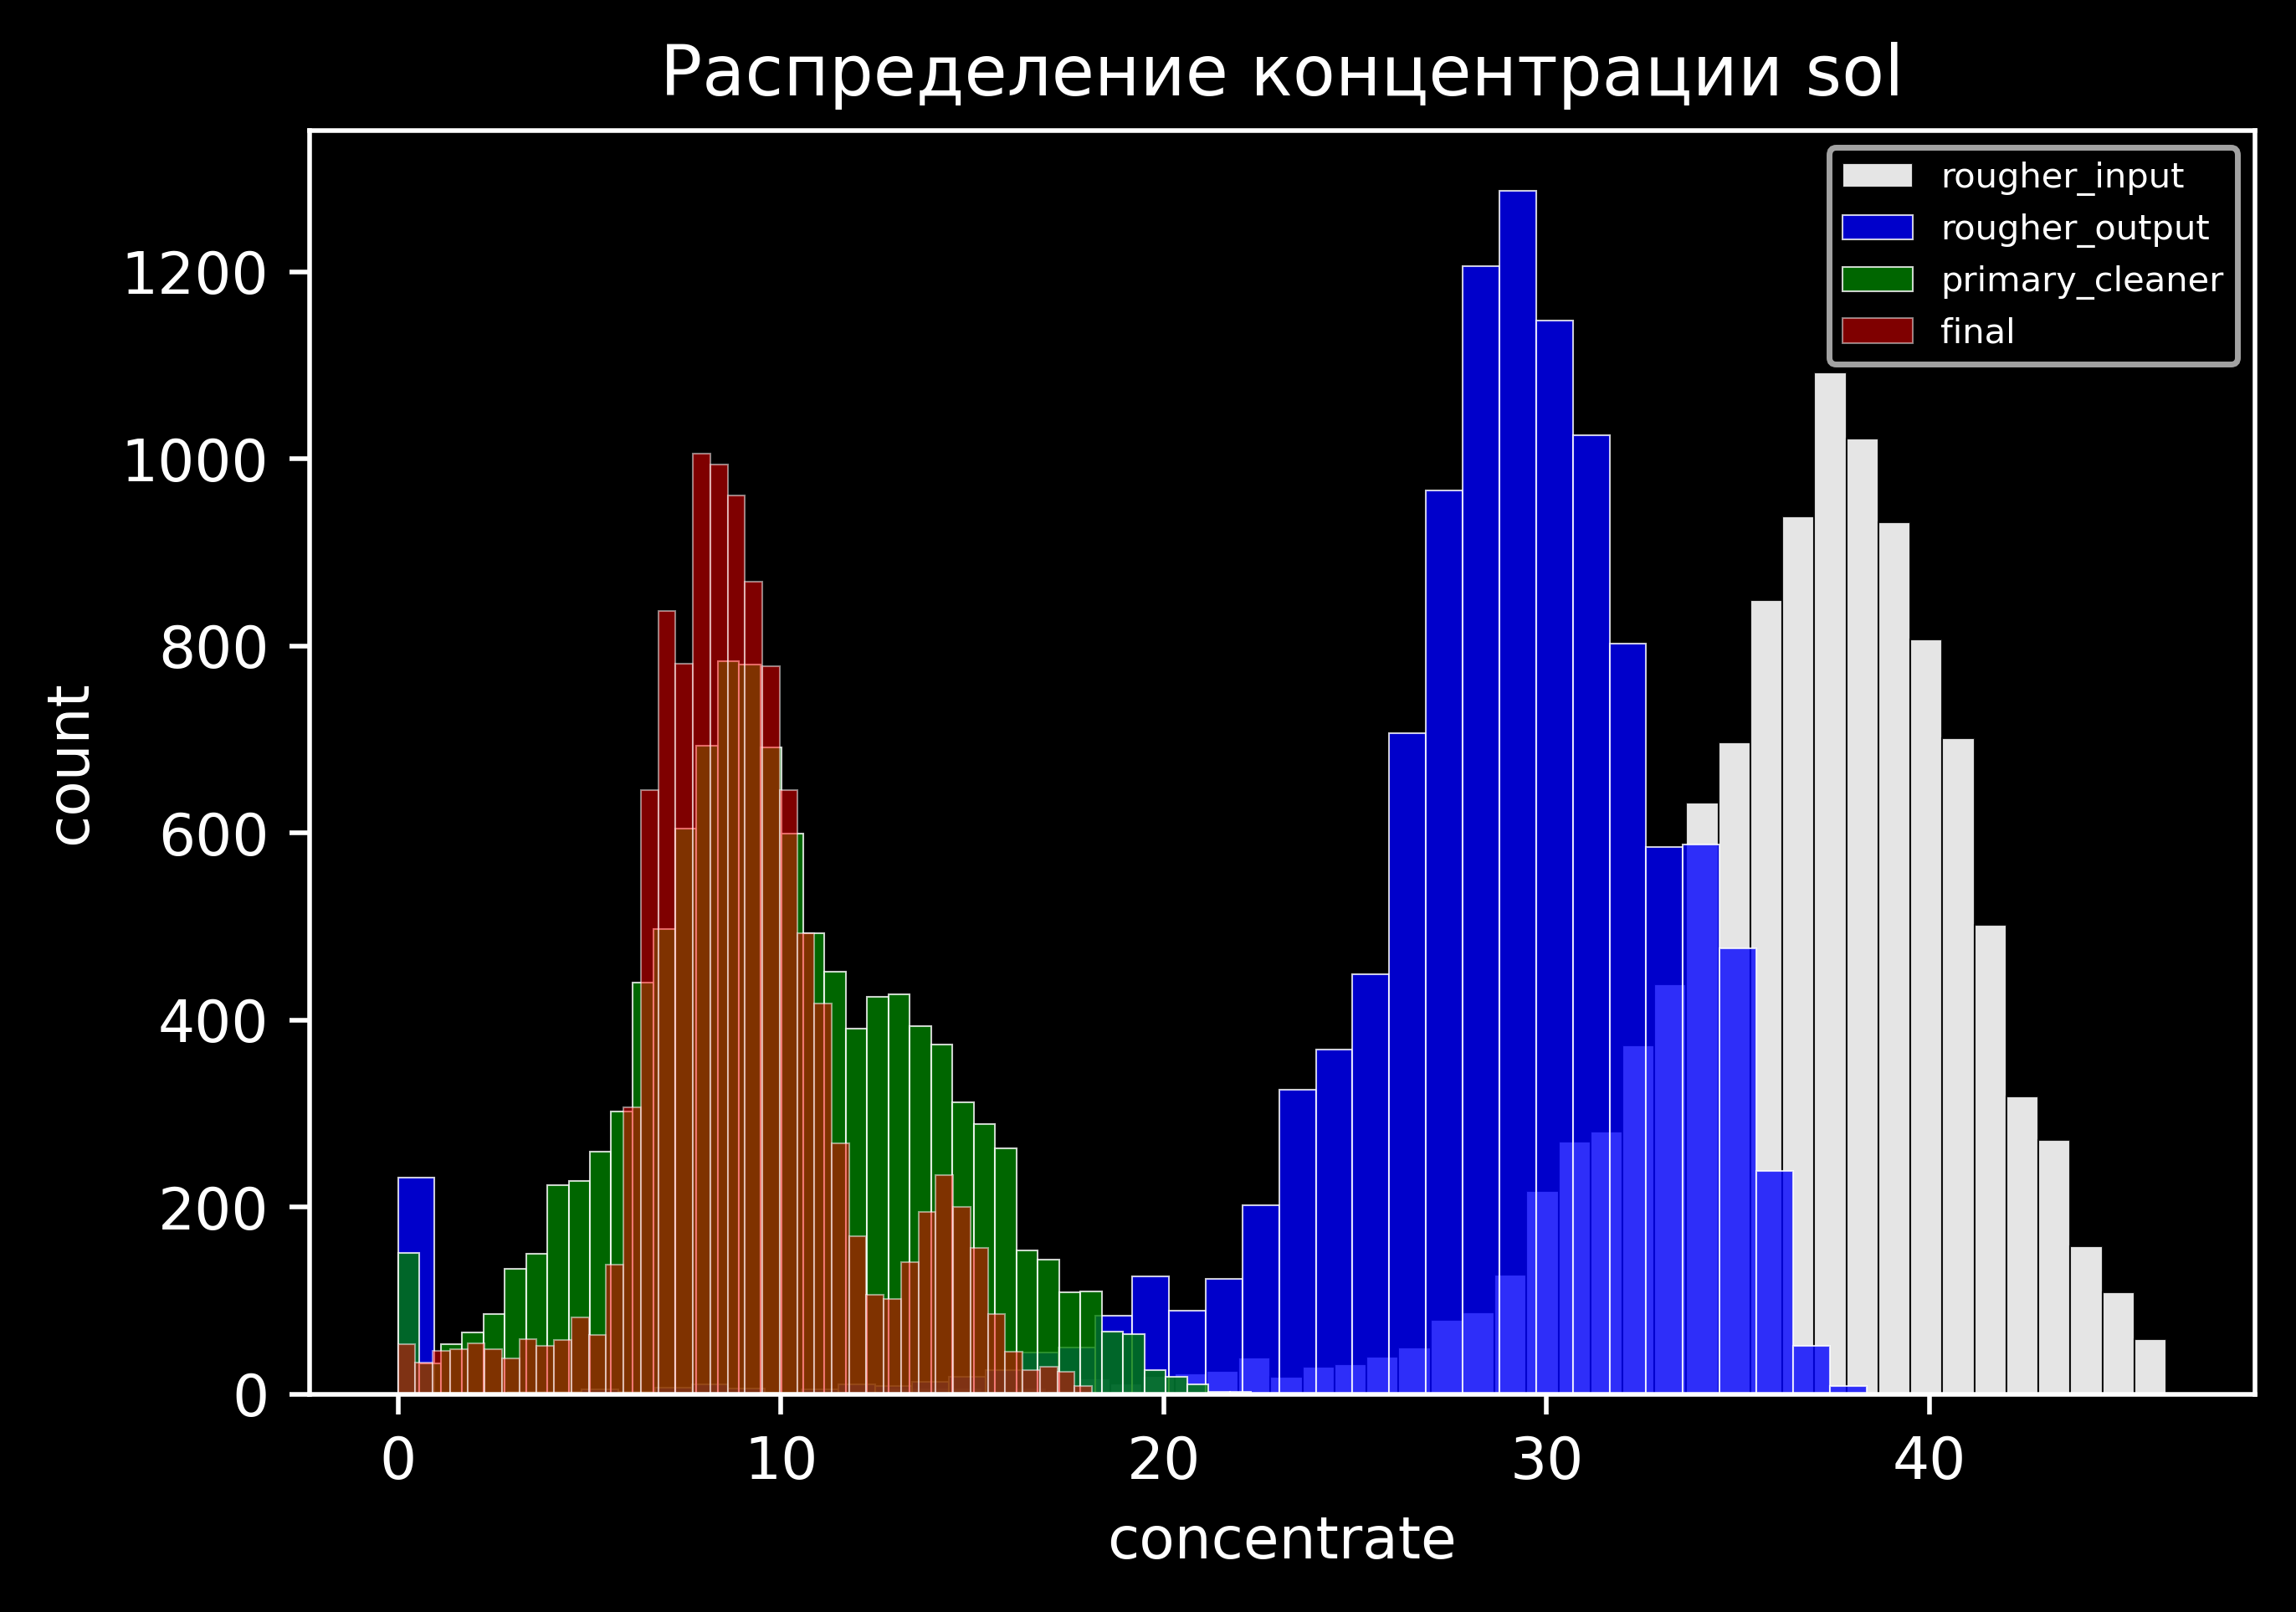

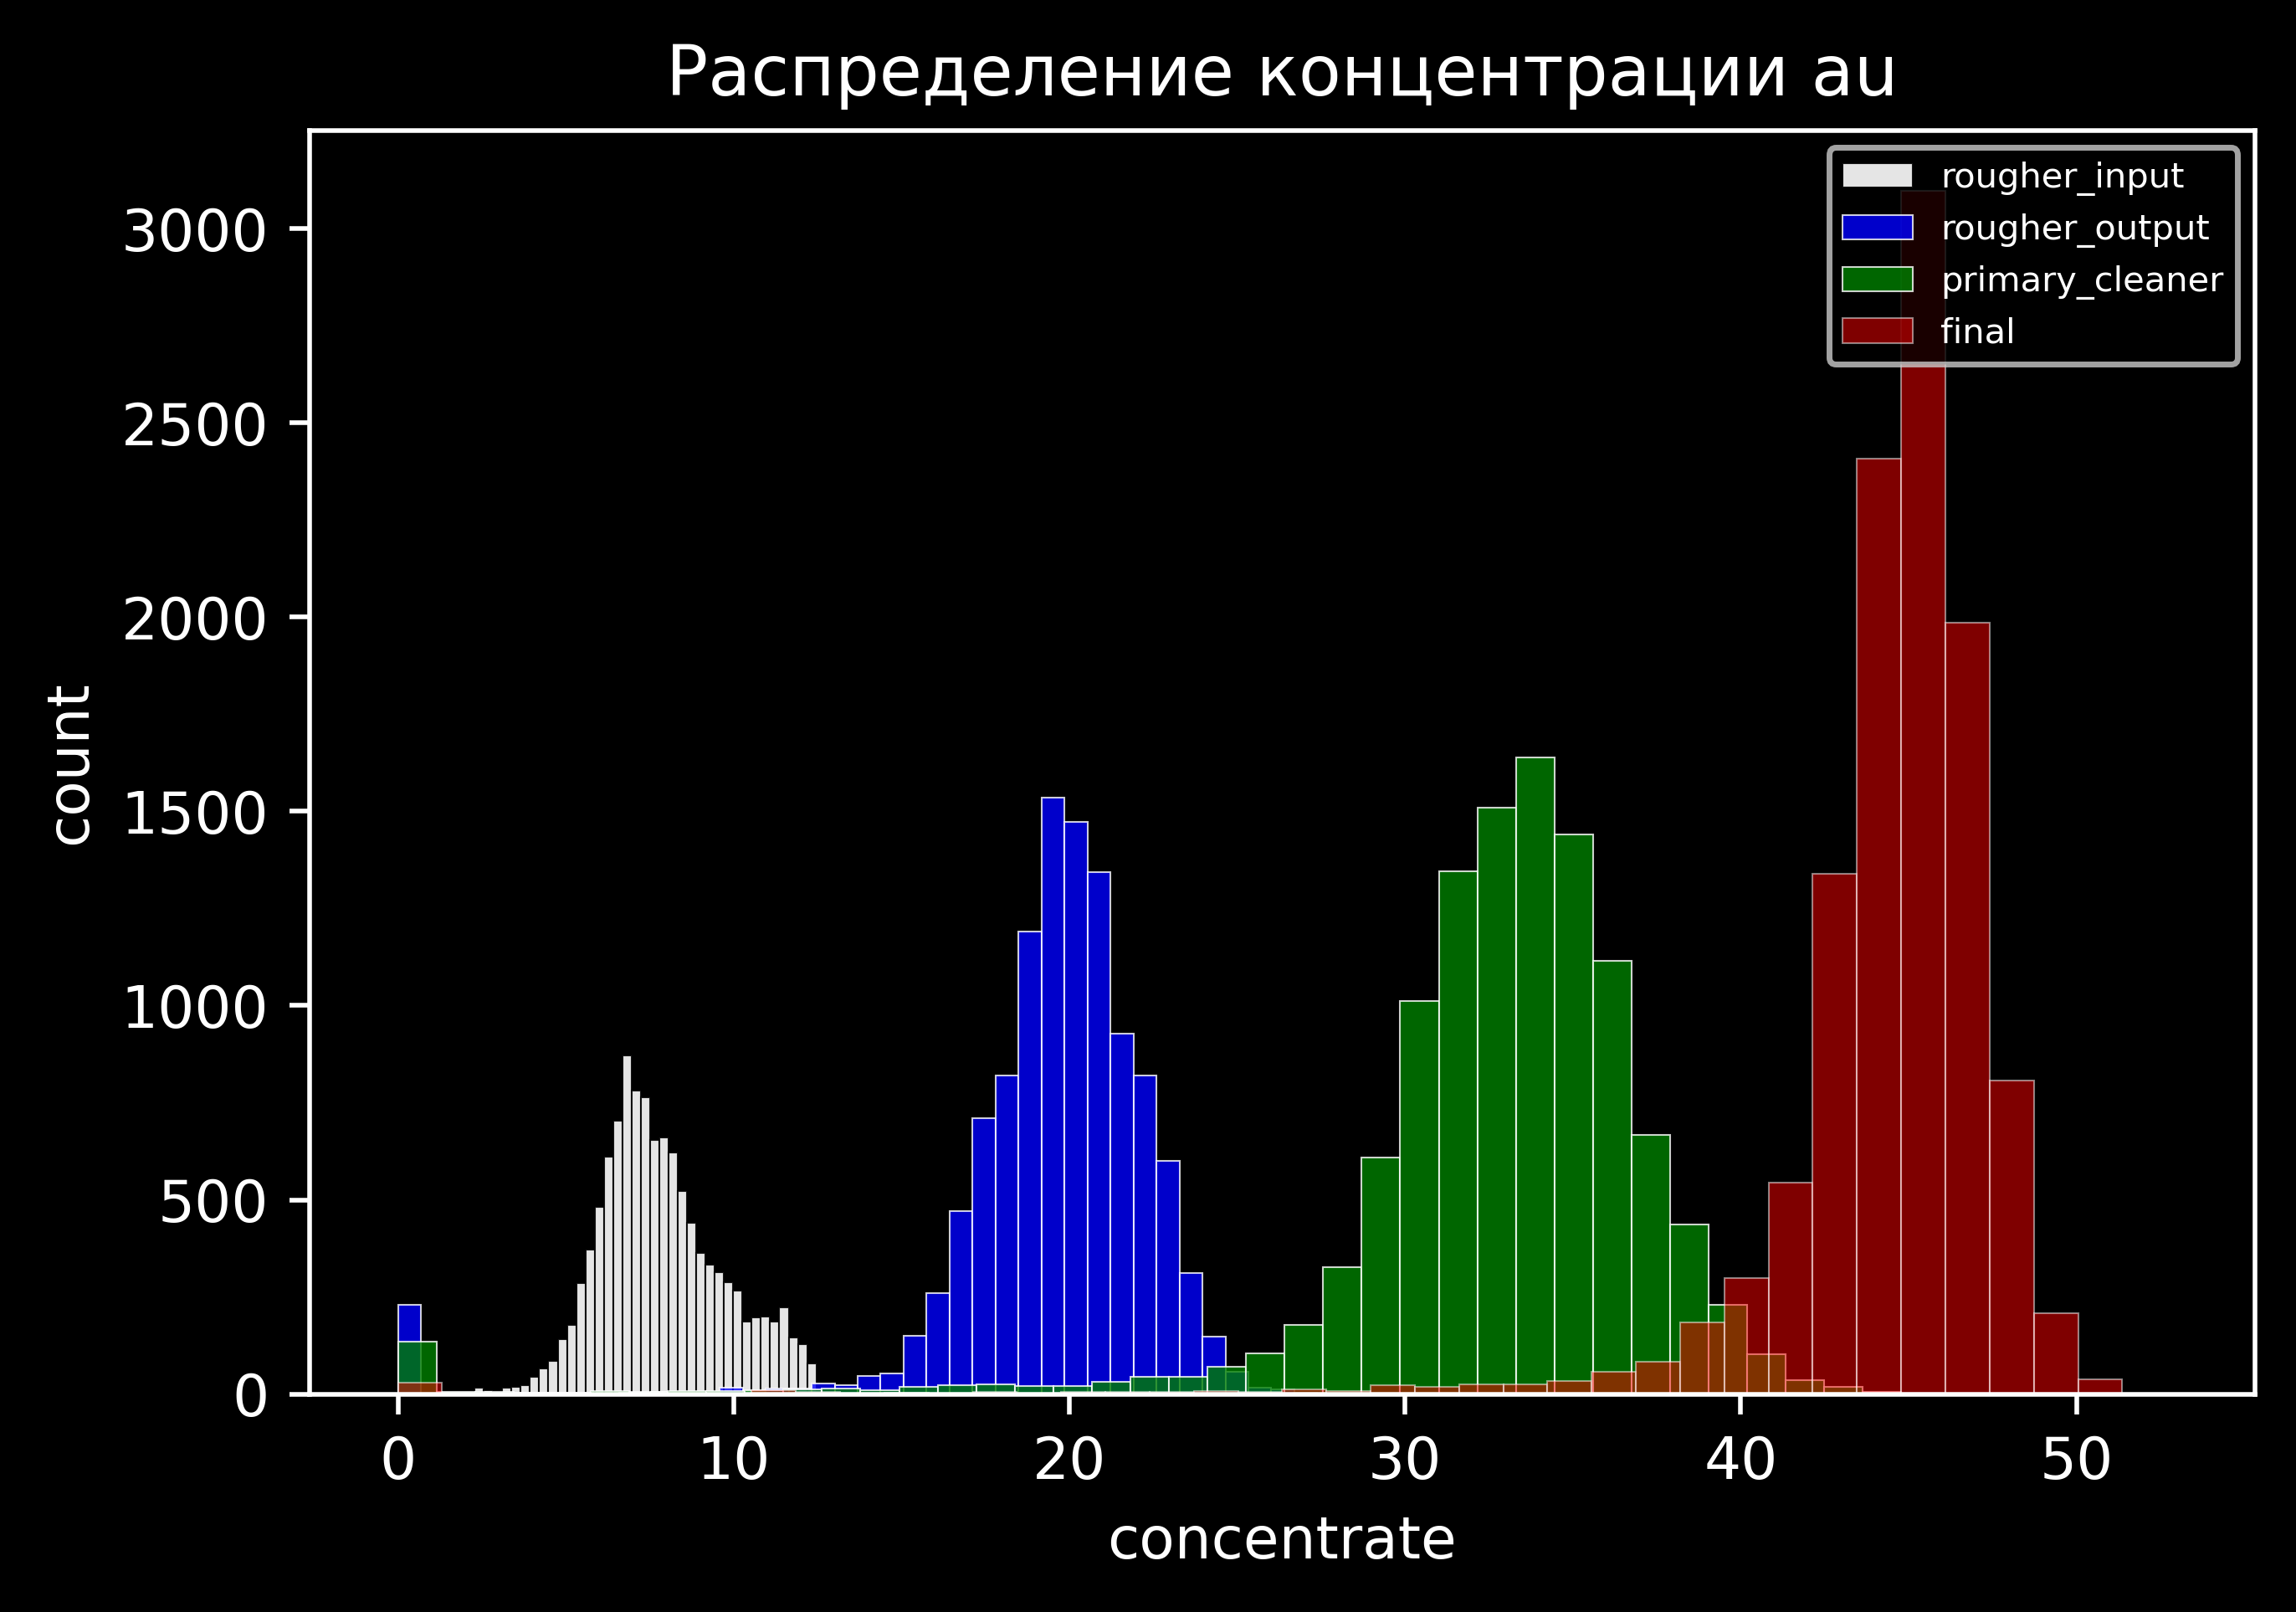

In [13]:
ind = list(data['train'].index)
df = data['full'].loc[ind]
columns = df.columns

items = ['ag', 'pb', 'sol', 'au']
steps = ['rougher_input', 'rougher_output', 'primary_cleaner', 'final']
for item in items:
    rougher_input = df[f'rougher.input.feed_{item}']
    rougher_output = df[f'rougher.output.concentrate_{item}']
    primary_cleaner = df[f'primary_cleaner.output.concentrate_{item}']
    final = df[f'final.output.concentrate_{item}']
    
    plt.style.use('dark_background')
    ax = plt.figure(dpi=500)
    plt.xlabel('concentrate')
    plt.ylabel('count')
    plt.title(f'Распределение концентрации {item}')
    
    plt.hist(rougher_input, bins=40, alpha = 0.9, color='white', linewidth=0.3, ec='black');
    plt.hist(rougher_output, bins=40, alpha = 0.8, color='blue', linewidth=0.3, ec='w');
    plt.hist(primary_cleaner, bins=40, alpha = 0.8, color='green', linewidth=0.3, ec='w');
    plt.hist(final, bins=40, alpha = 0.5, color='red', linewidth=0.3, ec='w');
    
    plt.legend(steps, loc='upper right', fontsize=6)
    plt.show




Из графиков распределений видно, что концентрация металлов на каждом этапе очистки распределена нормально. У концентрация серебра на последнем этапе ниже, чем на первом, для sol ситуация аналогичная. А концентрация золота и свинца с каждым этапом растет. Заметим, что концентрация <1 - это аномалия, которая может исказть результаты нашей модели, удалим такие значения.

In [14]:
items = ['ag', 'pb', 'sol', 'au']
steps = ['rougher_input', 'rougher_output', 'primary_cleaner', 'final']
for item in items:
    rougher_input = df[f'rougher.input.feed_{item}']
    rougher_output = df[f'rougher.output.concentrate_{item}']
    primary_cleaner = df[f'primary_cleaner.output.concentrate_{item}']
    final = df[f'final.output.concentrate_{item}']
    ind = list(set(rougher_input.loc[rougher_input>1].index) & 
               set(rougher_output.loc[rougher_output>1].index) & 
               set(primary_cleaner.loc[primary_cleaner>1].index) & 
               set(final.loc[final>1].index) & 
               set(data['train'].index))
    
    data['train'] = data['train'].loc[ind]

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. Видно, что золото растёт в концентрации - это здорово!) А серебро падает - ведь наша цель -  золото, верно?)
А свинец - это побочный элемент химических реакций, по этой причине немного и увеличивается его концентрация

#### 2.2. Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Требуемый столбец - rougher.input.feed_size

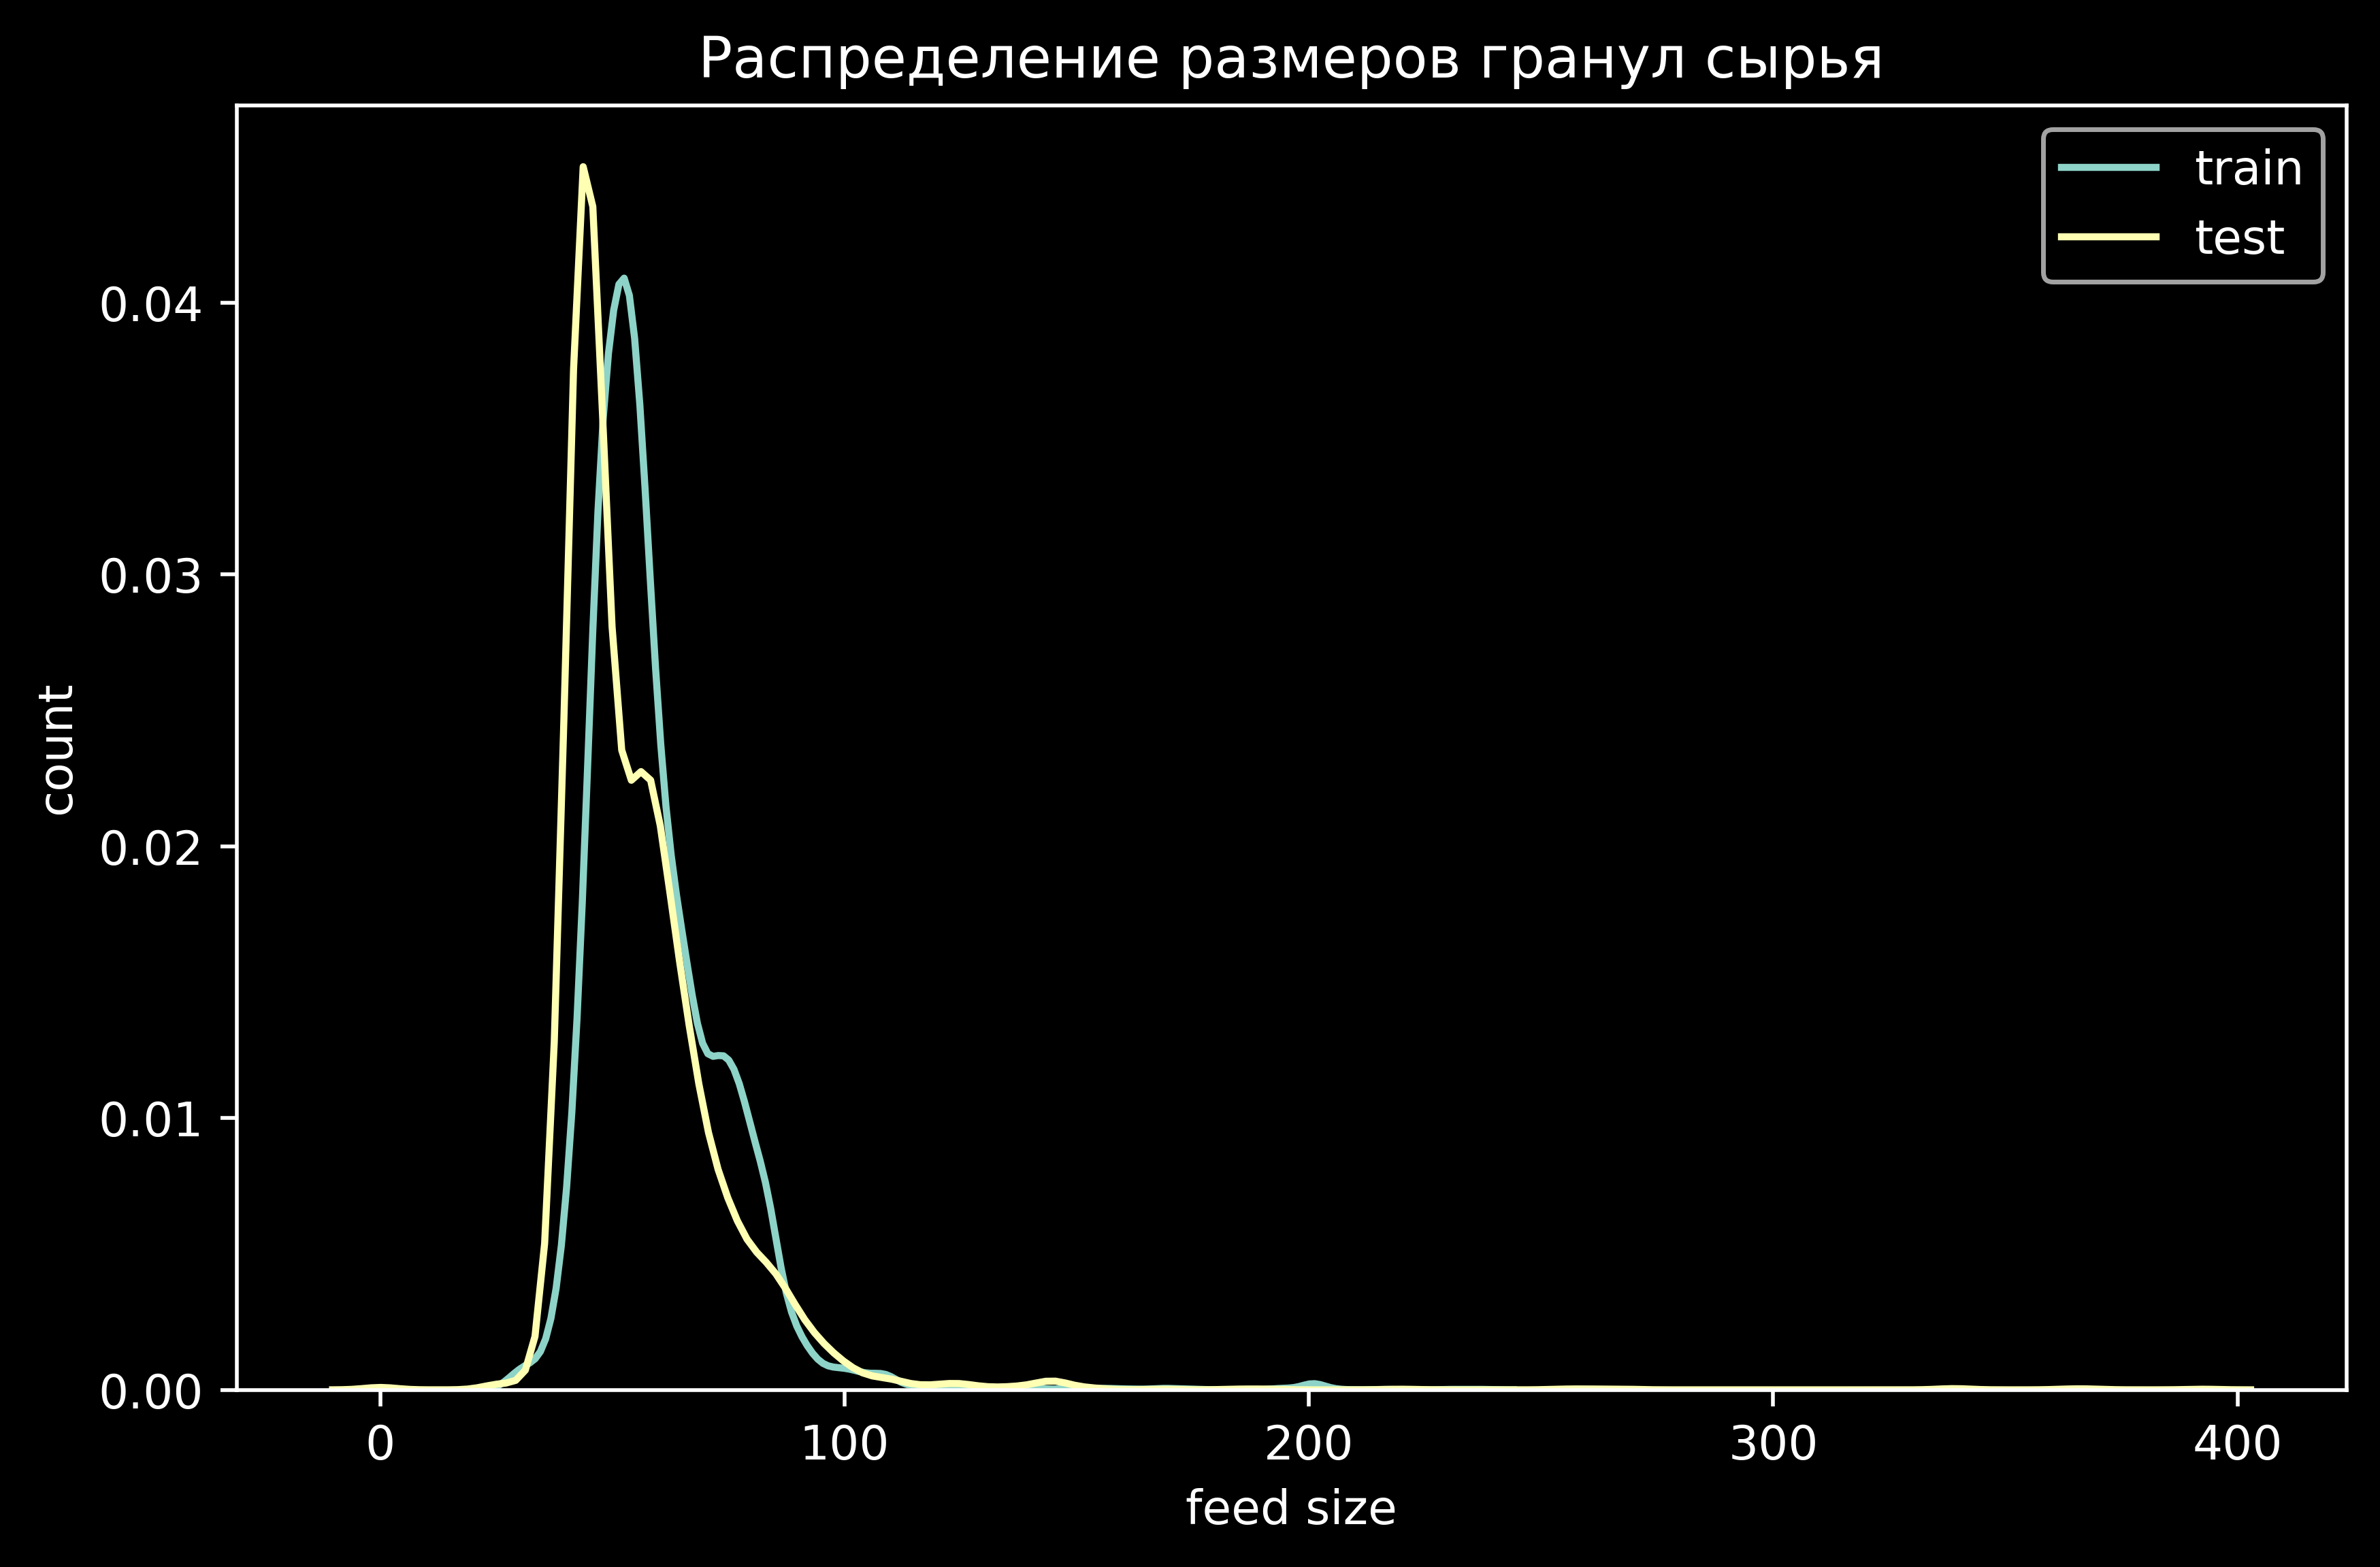

In [15]:
names = ['train', 'test']
colors = ['yellow', 'blue']
ax = plt.figure(dpi=500, figsize=(8,5))
plt.title('Распределение размеров гранул сырья')
for i, df in enumerate([data['train'], data['test']]): 
    sns.kdeplot(data=df['rougher.input.feed_size'])
plt.xlabel('feed size')
plt.ylabel('count')
plt.legend(labels=names)
plt.show()

Не смотря на некоторые расхождения в распределениях (сдвиг и высоту), видно, что вид обоих распределений напоминает суперпозицию двух распределениий (потому что по 2 пика) $Пуассона^*$ с небольшим параметром $\lambda$. 

$*  P_n(k) = \frac{\lambda^k}{k!} * e^\lambda$

#### 2.3. Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Сырье:

rougher.input.feed_ag

rougher.input.feed_au

rougher.input.feed_pb

rougher.input.feed_sol
_____
Черновой этап: 

rougher.output.concentrate_ag

rougher.output.concentrate_au

rougher.output.concentrate_pb

rougher.output.concentrate_sol
_____
Финальный этап: 

final.output.concentrate_ag

final.output.concentrate_pb

final.output.concentrate_sol

final.output.concentrate_au

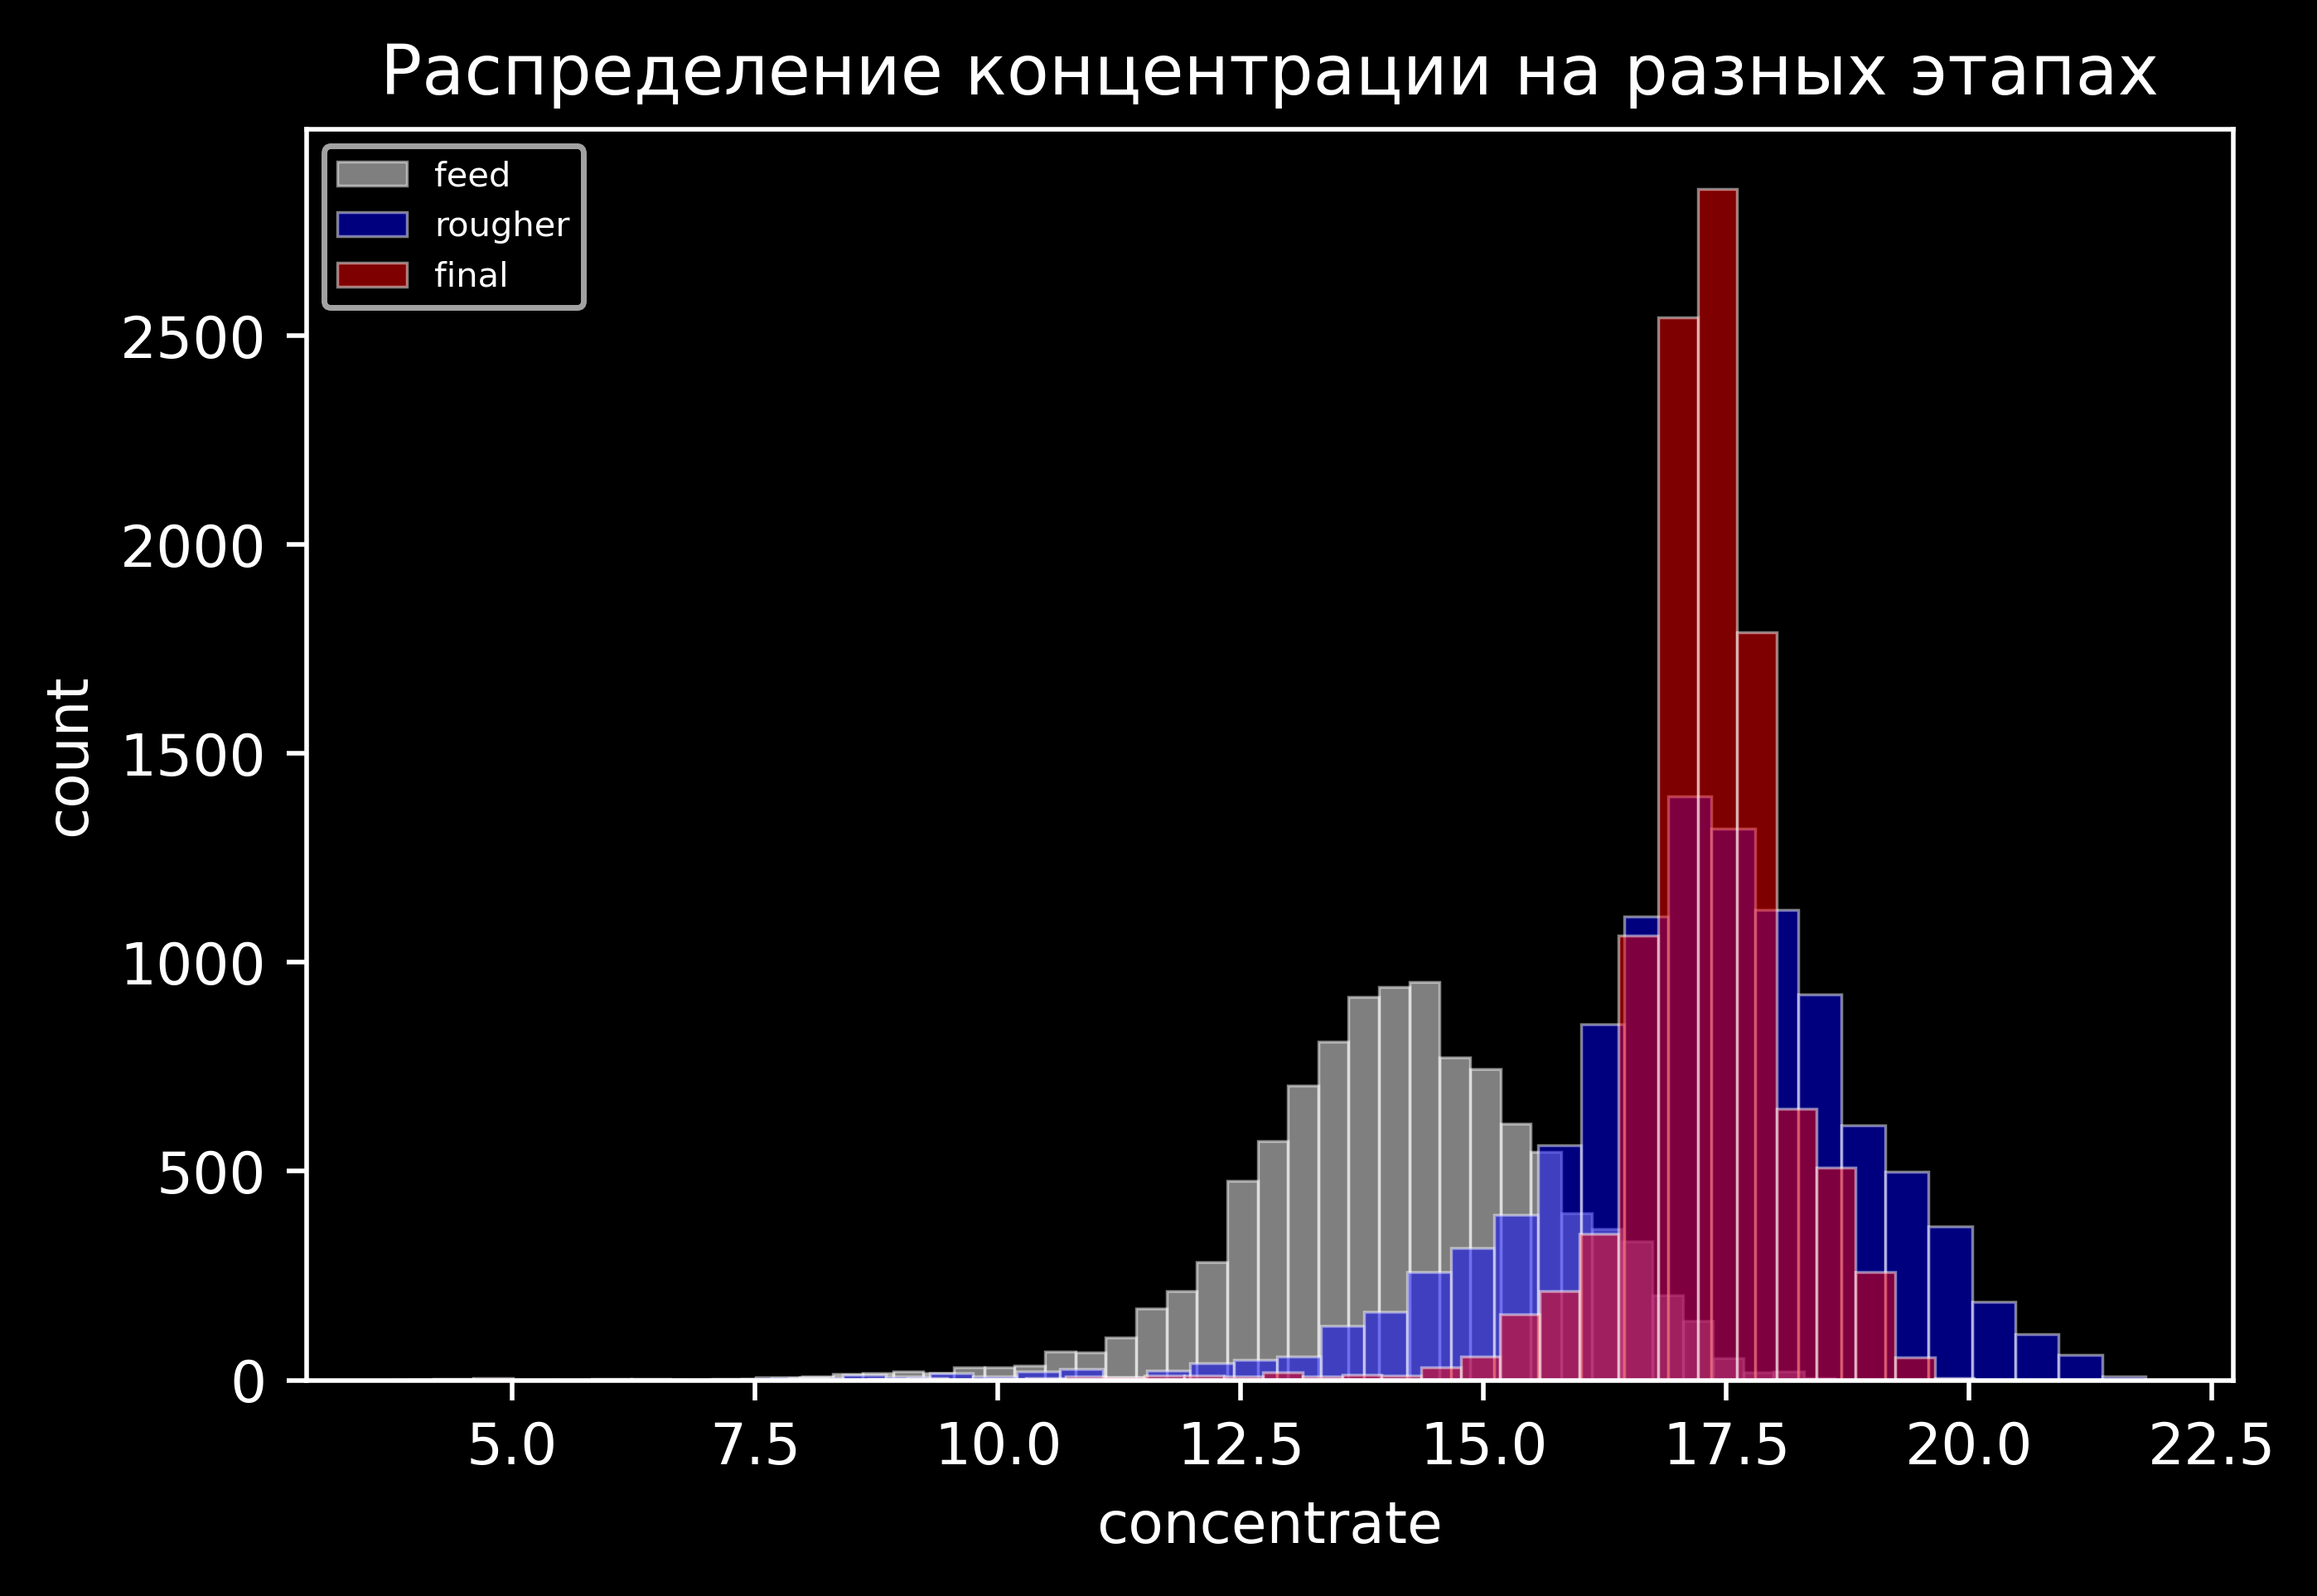

In [16]:
ind = list(data['train'].index)
df = data['full'].loc[ind]
columns = df.columns
items = ['ag', 'pb', 'sol', 'au']
feed, rougher, final = 0, 0, 0

for item in items:
    try: 
        feed += df[f'rougher.input.feed_{item}'] / 4
    except: 
        feed = df[f'rougher.input.feed_{item}'] / 4
    try: 
        rougher += df[f'rougher.output.concentrate_{item}'] / 4
    except: 
        rougher = df[f'rougher.output.concentrate_{item}'] / 4
    try:
        final += df[f'final.output.concentrate_{item}'] / 4
    except: 
        final = df[f'final.output.concentrate_{item}'] / 4
    
steps = ['feed', 'rougher', 'final']
colors = ['white', 'blue', 'red']

ax = plt.figure(dpi=500)
plt.xlabel('concentrate')
plt.ylabel('count')
plt.title(f'Распределение концентрации на разных этапах')
for i, item in enumerate([feed, rougher, final]):
    plt.hist(item, bins=40, alpha=0.5, color=colors[i], linewidth=0.3, ec='white', 
            lw=0.5);

    
plt.legend(steps, loc='upper left', fontsize=6)
plt.show()

Распределения похожи на нормальные. Средняя концентрация элементов имеет свойство расти с каждым этапом обработки. Дисперсия уменьшается.

#### 3.1. Написать функцию для вычисления итоговой sMAPE.

* #### $sMAPE = \frac{1}{N} \sum_{i=1}^N \frac{|y_i - y_i^*|}{(\frac{|y_i|+|y_i^*|}{2})} * 100\% $
    * $y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

    * $y_i^*$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
    
* #### $sMAPE_{total} = 25\% * sMAPE_{rougher} + 75\% * sMAPE_{final}$

In [18]:
# eps в знаменателе, чтобы не возникало деления на 0, так как в поиске лучшей 
# модели случайного леса иногда у меня появлялась ошибка 
def sMAPE(y_pred, y_test): 
    y_pred = np.array(y_pred)
    y_test = np.array(y_test) 
    N = len(y_pred)
    eps = y_pred * 0 + 1e-6
    sMAPE = 100 * abs(y_test - y_pred) / (0.5 * (abs(y_test) + abs(y_pred) 
                                                           + eps)) / N
    return sMAPE.sum()

def sMAPE_tot(sMAPE_rougher, sMAPE_final): 
    return sMAPE_rougher * 0.25 + sMAPE_final * 0.75 

#### 3.2. Обучить разные модели и оценить их качество кросс-валидацией. Выбрать лучшую модель и проверить её на тестовой выборке. Описание выводов.

Целевые признаки: 

    * rougher.output.recovery
    * final.output.recovery

Функция для масштабирования признаков и выбора целевого признака(один столбец)

In [19]:
def transform(df): 
    x = df.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).reset_index(drop=True)
    columns = x.columns
    
    y = df[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)
    return x, y

Функция для кросс-валидации с метрикой sMAPE

In [20]:
def cross_val(model, df, x, y, cv): 
    size = int(len(df) / cv)
    score = []
    for i in range(0, len(df) - size, size): 
        val_ind = list(range(i, i + size))
        train_ind = list(range(0, i)) + list(range(i + size, len(df)))
        
        x_train = x.loc[train_ind]
        y_train = y.loc[train_ind]
        
        x_valid = x.loc[val_ind]
        y_valid = y.loc[val_ind]
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_valid)
        score.append(sMAPE(y_pred, y_valid))
    return score     

In [21]:
rougher = 'rougher.output.recovery'
final = 'final.output.recovery'

train = data['train']
x_train, y_train = transform(train)

Кросс-валидация для линейной регрессии с метрикой sMAPE (со всеми колонками)

In [22]:
lin_reg_r = LinearRegression()
lin_reg_f = LinearRegression()

sMAPE_rougher = np.mean(cross_val(lin_reg_r, train, x_train, y_train[rougher], 5))
sMAPE_final = np.mean(cross_val(lin_reg_f, train, x_train, y_train[final], 5))

sMAPE_total = sMAPE_tot(sMAPE_rougher, sMAPE_final)
print('sMAPE_rougher:',round(sMAPE_rougher,3))
print('sMAPE_final:',round(sMAPE_final, 3))
print('sMAPE_total:', round(sMAPE_total, 3))

sMAPE_rougher: 4.162
sMAPE_final: 7.02
sMAPE_total: 6.305


#### Подбор параметров для случайного леса
Подбирались такие параметры отдельно для моделей rougher и final: 
* n_estimators 
* max_depth
* max_features
* min_samples_leaf 

Подбор параметров для rougher

In [23]:
%%time
# 2min 22s
best_score = 100000
best_depth_rougher = 1
min_samples_leaf_rougher = 1
max_features_rougher = x_train.shape[1]

for depth in range(1, 20): 
    for min_samples_leaf in range(1,8):
        model_r = RandomForestRegressor(n_estimators = 4,
                                        max_depth=depth, 
                                        n_jobs=-1, 
                                        min_samples_leaf = min_samples_leaf,
                                        random_state=RND)
        
        sMAPE_rougher = np.mean(cross_val(model_r, train, x_train, y_train[rougher], 5))
        if best_score > sMAPE_rougher: 
            best_score = sMAPE_rougher
            best_depth_rougher = depth
            min_samples_leaf_rougher = min_samples_leaf
        
for max_f in range(1, x_train.shape[1] + 1): 
    model_r = RandomForestRegressor(n_estimators = 4,
                                    max_depth=best_depth_rougher, 
                                    n_jobs=-1, 
                                    max_features=max_f,
                                    min_samples_leaf = min_samples_leaf_rougher,
                                    random_state=RND)
        
    sMAPE_rougher = np.mean(cross_val(model_r, train, x_train, y_train[rougher], 5))
    if best_score > sMAPE_rougher: 
        best_score = sMAPE_rougher
        max_features_rougher = max_f
       
print('Лучший sMAPE_rougher:', round(best_score, 3))
print('Оптимальная глубина:', best_depth_rougher)
print('Оптимальный max_features:', max_features_rougher)
print('Оптимальный min_samples_leaf:', min_samples_leaf_rougher)


Лучший sMAPE_rougher: 2.659
Оптимальная глубина: 17
Оптимальный max_features: 30
Оптимальный min_samples_leaf: 5
CPU times: user 8min 45s, sys: 2.34 s, total: 8min 48s
Wall time: 2min 23s


Подбор параметров для final

In [24]:
%%time
#8min 48s
best_score = 100000
best_depth_final = 1
min_samples_leaf_final = 1
max_features_final = train.shape[1]
time = 0

for depth in range(1, 20): 
    for min_samples_leaf in range(1,8):
        model_f = RandomForestRegressor(n_estimators = 4,
                                        max_depth=depth, 
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=RND)
                
        sMAPE_final = np.mean(cross_val(model_f, train, x_train, y_train[final], 5))
        if best_score > sMAPE_final: 
            best_score = sMAPE_final
            best_depth_final = depth
            min_samples_leaf_final = min_samples_leaf
            
for max_f in range(1, x_train.shape[1] + 1): 
    model_f = RandomForestRegressor(n_estimators = 4,
                                    max_depth=best_depth_final, 
                                    min_samples_leaf=min_samples_leaf_final,
                                    max_features=max_f,
                                    random_state=RND)
                
    sMAPE_final = np.mean(cross_val(model_f, train, x_train, y_train[final], 5))
    if best_score > sMAPE_final: 
        max_features_final = max_f
        best_score = sMAPE_final
    
print('Лучший sMAPE_final:', round(best_score, 3))
print('Оптимальная глубина:', best_depth_final)
print('Оптимальный max_features:', max_features_final)
print('Оптимальный min_samples_leaf:', min_samples_leaf_final)

Лучший sMAPE_final: 5.699
Оптимальная глубина: 18
Оптимальный max_features: 32
Оптимальный min_samples_leaf: 6
CPU times: user 8min 55s, sys: 1.59 s, total: 8min 57s
Wall time: 8min 58s


Проверка моделей на большом количестве деревьев.

In [25]:
%%time
# 31.9 s
model_r = RandomForestRegressor(n_estimators = 150, 
                                max_depth=best_depth_rougher, 
                                min_samples_leaf = min_samples_leaf_rougher,
                                max_features=max_features_rougher,
                                n_jobs=-1,
                                random_state=RND)

model_f = RandomForestRegressor(n_estimators = 150, 
                                max_depth=best_depth_final,
                                max_features = max_features_final, 
                                min_samples_leaf = min_samples_leaf_final,
                                n_jobs=-1,
                                random_state=RND)

sMAPE_rougher = np.mean(cross_val(model_r, train, x_train, y_train[rougher], 5))
sMAPE_final = np.mean(cross_val(model_f, train, x_train, y_train[final], 5))
sMAPE_total = sMAPE_tot(sMAPE_rougher, sMAPE_final)

print('sMAPE_rougher:',round(sMAPE_rougher,3))
print('sMAPE_final:',round(sMAPE_final, 3))
print('sMAPE_total:', round(sMAPE_total, 3))

sMAPE_rougher: 2.349
sMAPE_final: 5.114
sMAPE_total: 4.422
CPU times: user 4min 47s, sys: 1.18 s, total: 4min 48s
Wall time: 39.6 s


Модель случайного леса показала результат выше, чем линейная регрессия, однако обе модели показали хорошее качество (чем меньше метрика sMAPE, тем больше предсказания совпадают с тестом). Модель случайного леса работает сильно медленнее, чем линейная регрессия, это связано с большим объемом данных и методом кросс-валидации, ведь в ней приходится проводить обучение несколько раз. 

#### Проверка лучшей модели на тестовой выборке. 

In [26]:
%%time
# 8.03 s
model_r = RandomForestRegressor(n_estimators = 150, 
                                max_depth=best_depth_rougher,
                                max_features=max_features_rougher,
                                min_samples_leaf = min_samples_leaf_rougher,
                                n_jobs=-1,
                                random_state=RND)

model_f = RandomForestRegressor(n_estimators = 150, 
                                max_depth=best_depth_final, 
                                max_features=max_features_final,
                                min_samples_leaf = min_samples_leaf_final,
                                n_jobs=-1,
                                random_state=RND)

model_r.fit(x_train, y_train[rougher])
model_f.fit(x_train, y_train[final]);


CPU times: user 1min 13s, sys: 339 ms, total: 1min 14s
Wall time: 10.4 s


RandomForestRegressor(max_depth=18, max_features=32, min_samples_leaf=6,
                      n_estimators=150, n_jobs=-1, random_state=123)

In [27]:
indicies = data['test'].index

test = data['test'].copy()
test[rougher] = data['full'].loc[indicies, rougher]
test[final] = data['full'].loc[indicies, final]

x_test, y_test = transform(test)

y_pred_rougher = model_r.predict(x_test)
y_pred_final = model_f.predict(x_test)

sMAPE_rougher = sMAPE(y_pred_rougher, y_test[rougher])
sMAPE_final = sMAPE(y_pred_final, y_test[final])

sMAPE_total = sMAPE_tot(sMAPE_rougher, sMAPE_final)
print('sMAPE_rougher:',round(sMAPE_rougher,3))
print('sMAPE_final:',round(sMAPE_final, 3))
print('sMAPE_total:', round(sMAPE_total, 3))

sMAPE_rougher: 7.912
sMAPE_final: 9.306
sMAPE_total: 8.958


### Сравнение с константной моделью (медиана по целевому признаку)

In [28]:
y_constant_r = [y_test[rougher].median()] * len(y_test)
y_constant_f = [y_test[final].median()] * len(y_test)
sMAPE_rougher = sMAPE(y_constant_r, y_test[rougher])
sMAPE_final = sMAPE(y_constant_f, y_test[final])

sMAPE_total = sMAPE_tot(sMAPE_rougher, sMAPE_final)
print('sMAPE_rougher:',round(sMAPE_rougher,3))
print('sMAPE_final:',round(sMAPE_final, 3))
print('sMAPE_total:', round(sMAPE_total, 3))

sMAPE_rougher: 8.057
sMAPE_final: 9.167
sMAPE_total: 8.889


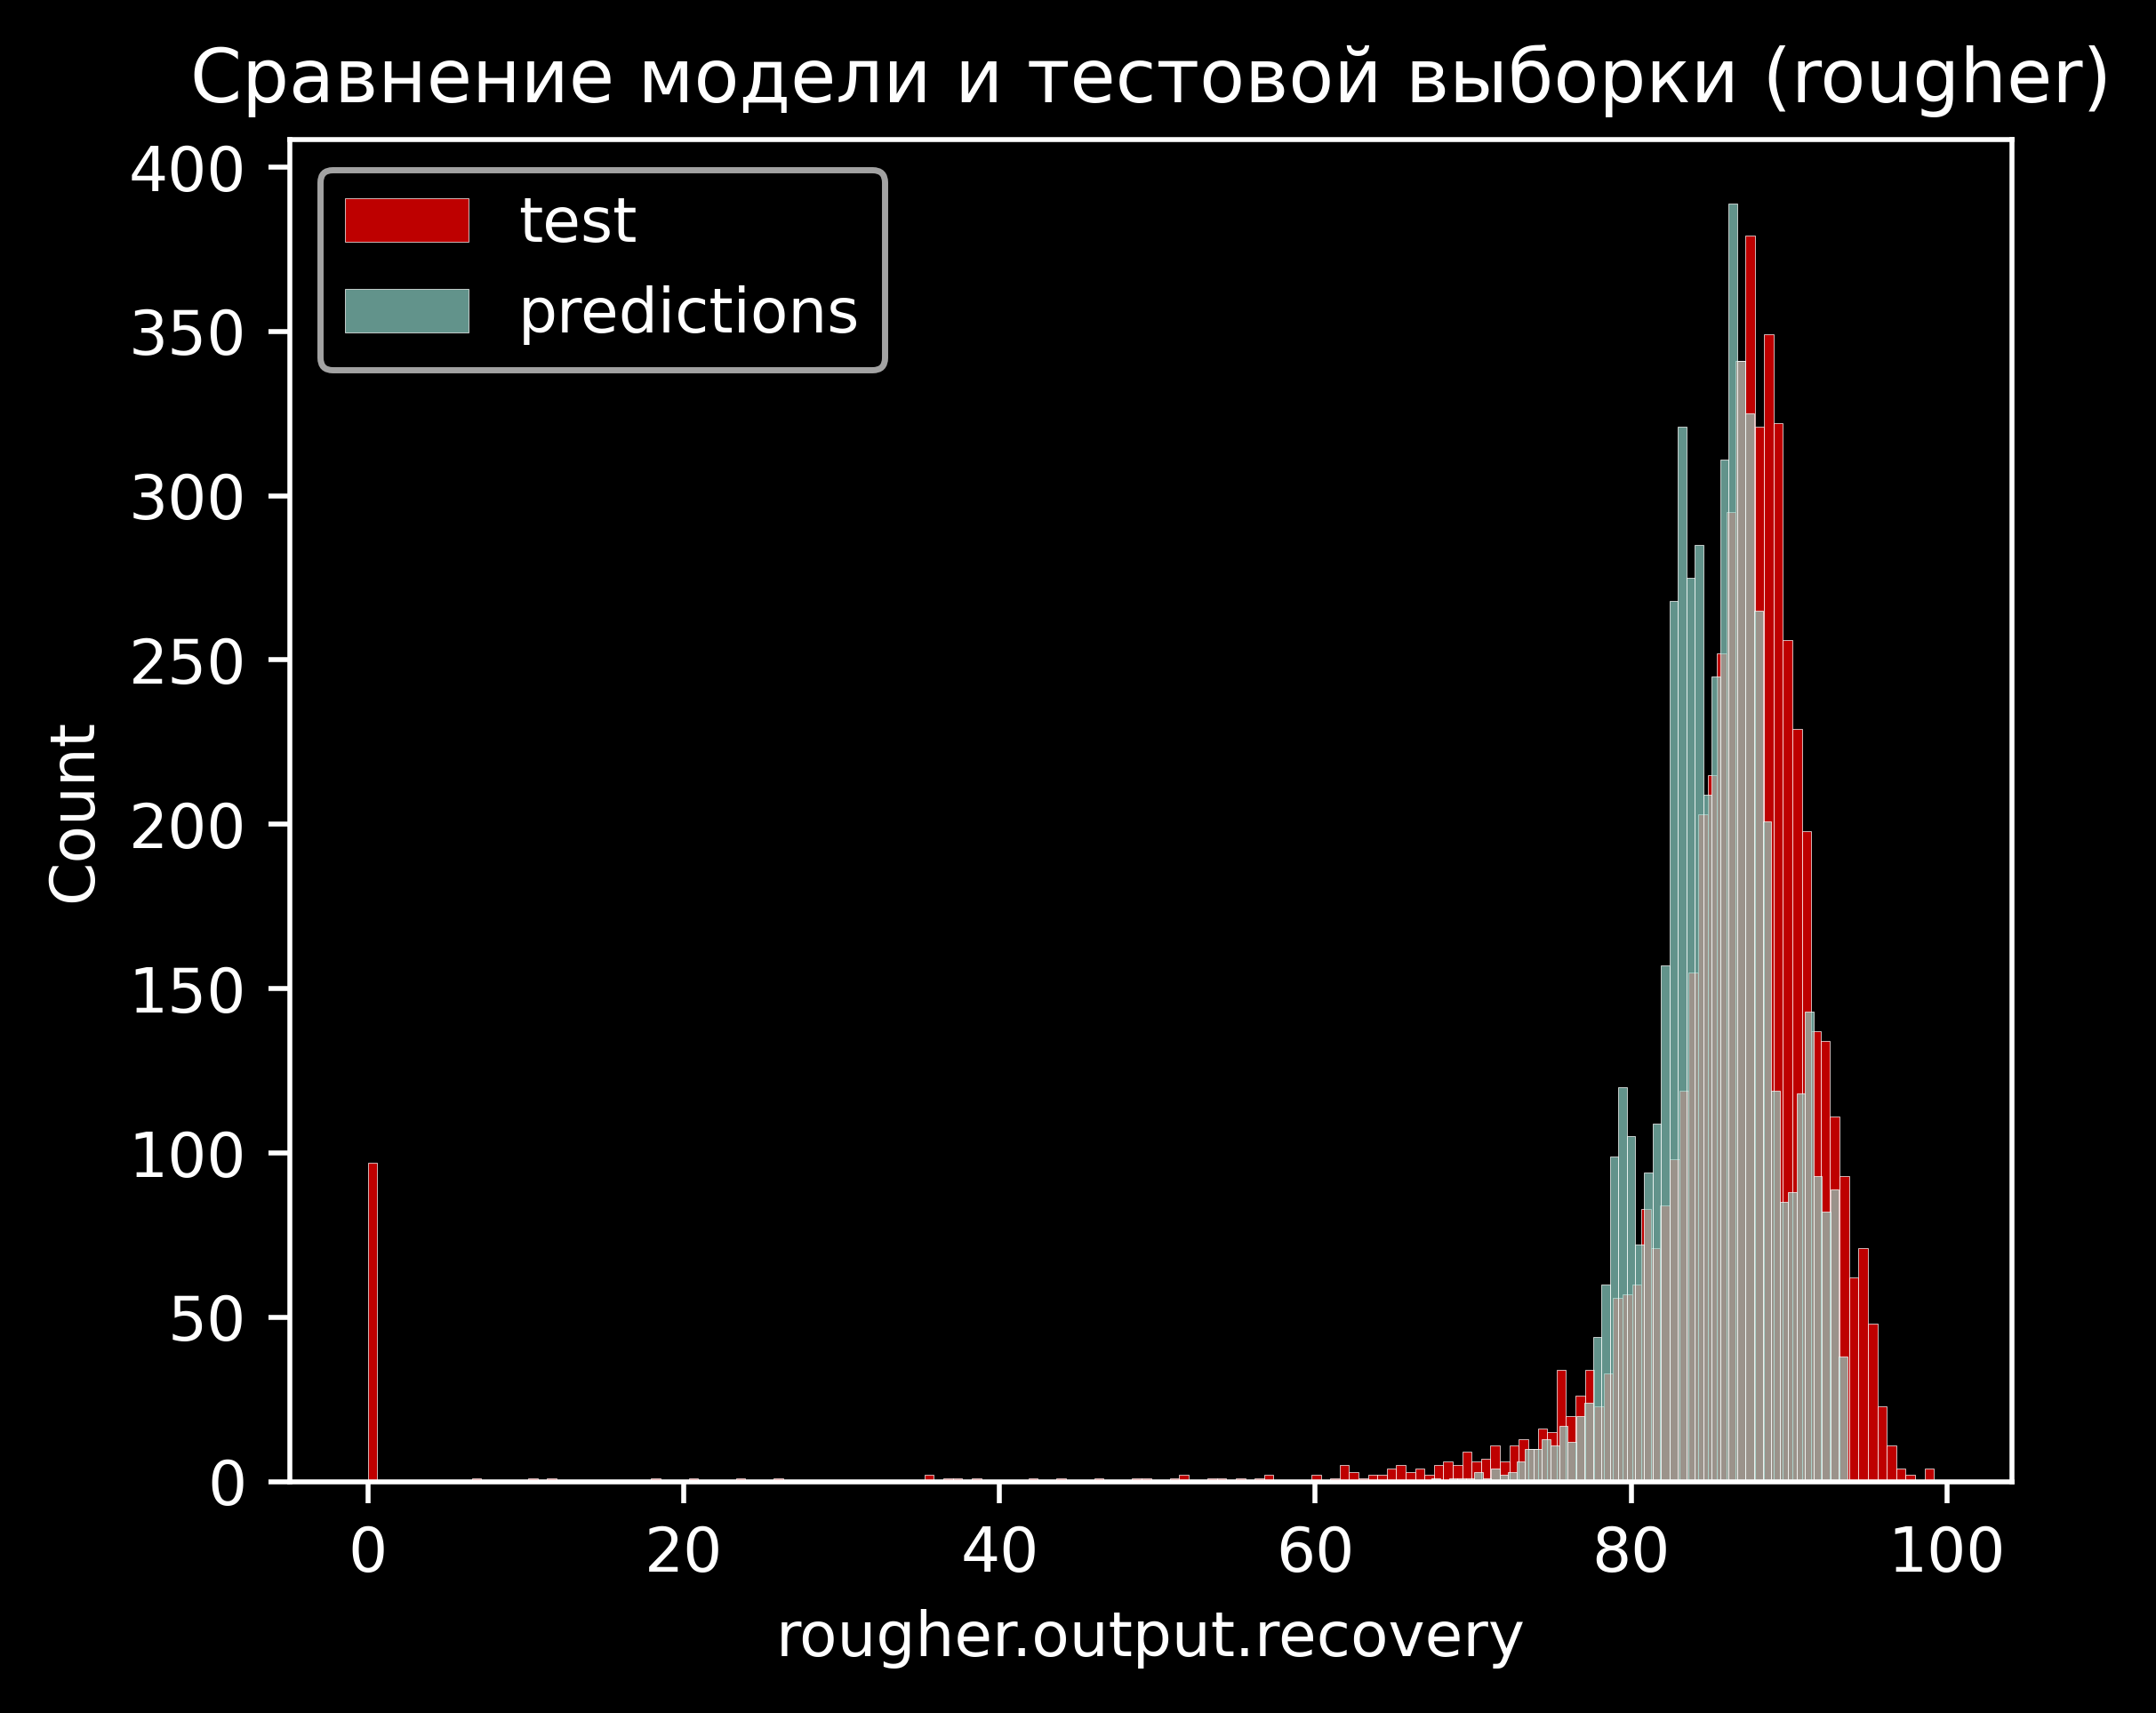

In [29]:
plt.style.use('dark_background')
ax = plt.figure(dpi=500, figsize=(5,4))

plt.title('Сравнение модели и тестовой выборки (rougher)')

sns.histplot(data=y_test[rougher], color='red', lw=0.1)
sns.histplot(data=y_pred_rougher, alpha=0.7, lw=0.1)

plt.legend(['test', 'predictions'], loc='upper left')
plt.show()

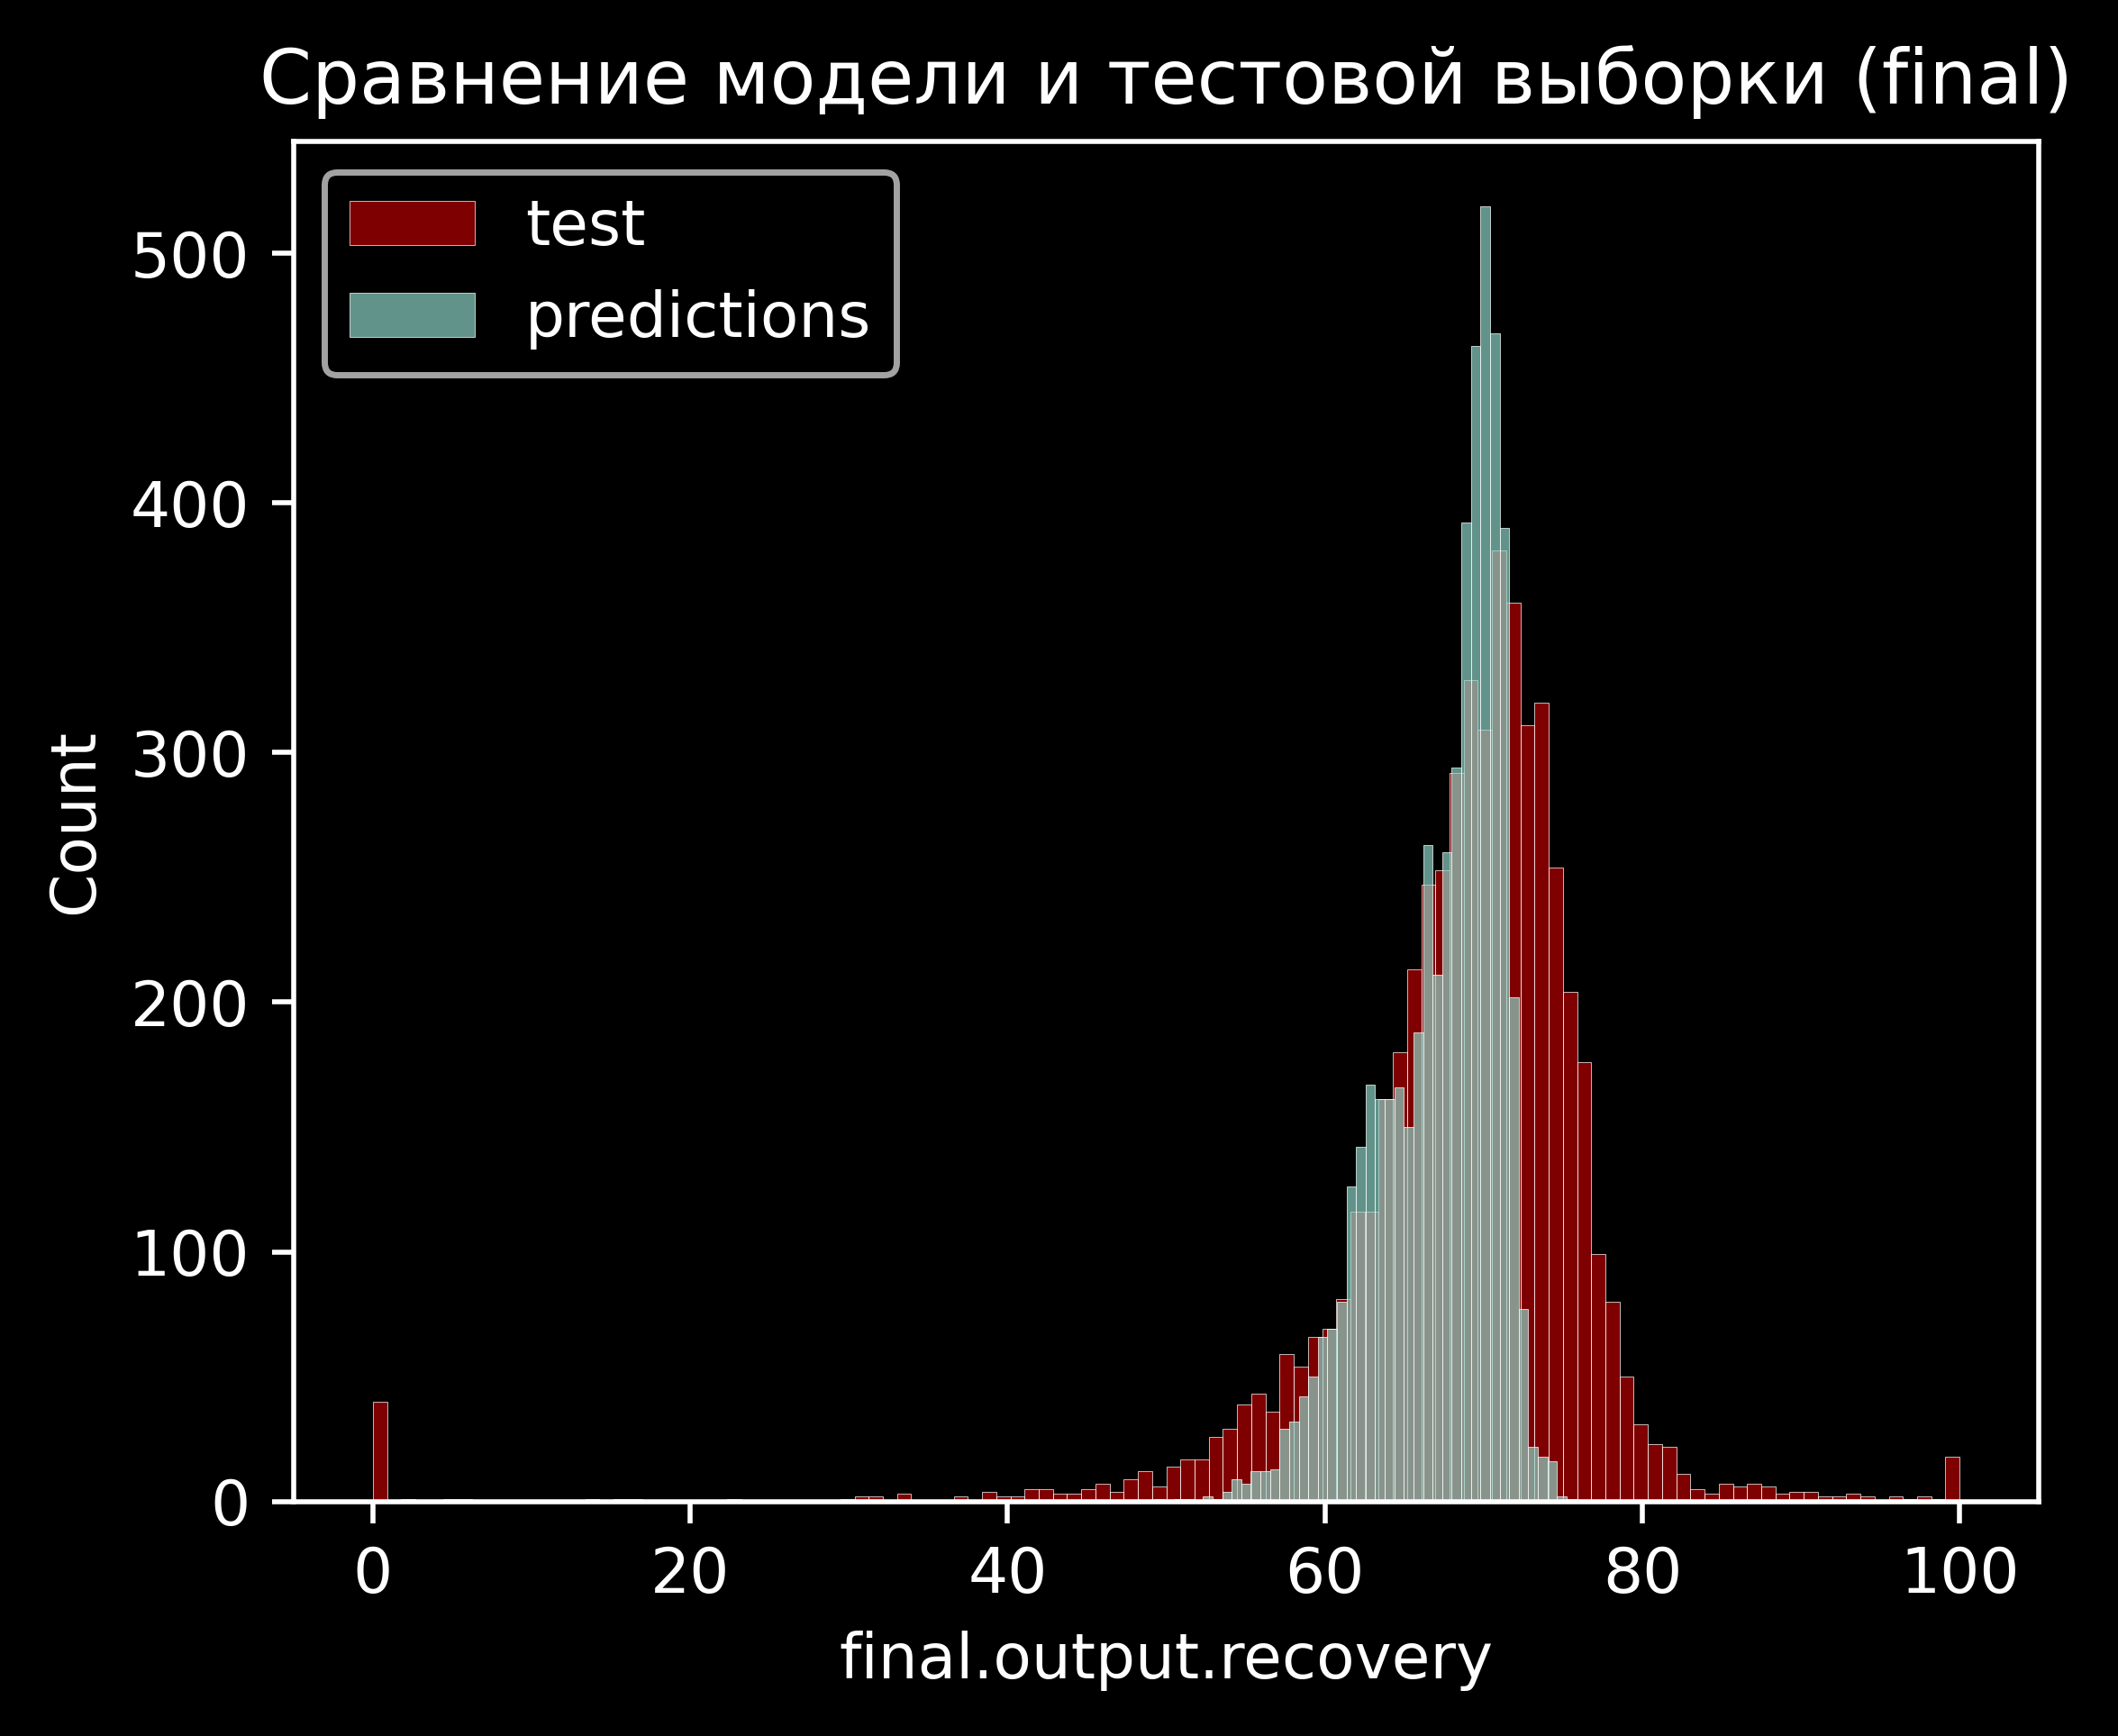

In [30]:
ax = plt.figure(dpi=500, figsize=(5,4))

plt.title('Сравнение модели и тестовой выборки (final)')

sns.histplot(data=y_test[final], color='red', alpha=0.5, lw=0.1)
sns.histplot(data=y_pred_final,  alpha=0.7, lw=0.1)

plt.legend(['test', 'predictions'], loc='upper left')
plt.show()

Модель случайного леса показала sMAPE = 9.2%, константная модель - 8.89%. Можно отметить, что у всех моделей метрика качества для первичной обработки была лучше, чем у финальной - то же самое можно увидеть и на графике. 

# Выводы

В проекте был обработан датасет с информацией об очистке руды. В тестовой выборке не было информации о столбцах, при помощи которых можно точно вычислить необходимые целевые признаки, поэтому целью данного проекта было построить модель, определяющую целевые признаки (добычу руды при первичной и финальной очистке) без использования недостающих характеристик. 


* Пропуски в обучающей выборке былы заполнены значениями из предыдущих строк, так-как показания измерялись с интервалом 1 час и соседние значения не должны сильно отличаться. 


* В процессе исследования гистограмм распределения концентрациии металлов в руде на каждом этапе очистки выяснилось, что концентрация металлов на каждом этапе очистки распределена нормально. Концентрация серебра на последнем этапе ниже, чем на первом, для sol ситуация аналогичная. Концентрация золота и свинца с каждым этапом растет. Суммарная концентрация всех металлов растет. 

* Для определения целевых признаков сравнивались две модели: линейная регрессия и случайный лес. Для проверки моделей на качество был выбран метод кросс-валидации с 5 подвыборками и метрика sMAPE. Обе модели показывали более высокое качество для финальной обработки, чем для первичной. Модель случайного леса показала лучший результат: sMAPE_total = 4.4% против 6.3% у  линейной регрессии. В случайном лесе было построено две модели (по одной на каждый целевой признак).


* На тестовой выборке модель случайного леса показала такие результаты:
    - sMAPE_rougher: 7.865
    - sMAPE_final: 9.25
    - sMAPE_total: 8.904
* Константная модель показала результаты: 
    - sMAPE_rougher: 8.057
    - sMAPE_final: 9.167
    - sMAPE_total: 8.889
    
При сравнении распределений предсказаний модели и тестовой выборки можно видеть, что модель хорошо определила пик распределения и с избытком оценила низкие значения recovery, то есть мы точно не запустим убыточные предприятия, что и является главной целью проекта.